In [1]:
import json
import os

from find_dataset import locate

DATA = locate("Datasets") / "processed"

print(f"Datasets: {DATA}")

Datasets: /home/cethan/GitHub/542-LegalContract-AI/Datasets/processed


In [2]:
with open(DATA / "contractnli.json") as f:
    cnli = json.load(f)

with open(DATA / "cuad.json") as f:
    cuad = json.load(f)

In [7]:
cuad_text = [i["text"] for i in cuad]
cnli_text = [i["text"] for i in cnli]

## CUAD Only

The code below is yoinked from [scikit-learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py).

Extracting tf-idf features for NMF...
done in 1.574s.
Extracting tf features for LDA...
done in 1.352s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_features=1000...
done in 0.490s.


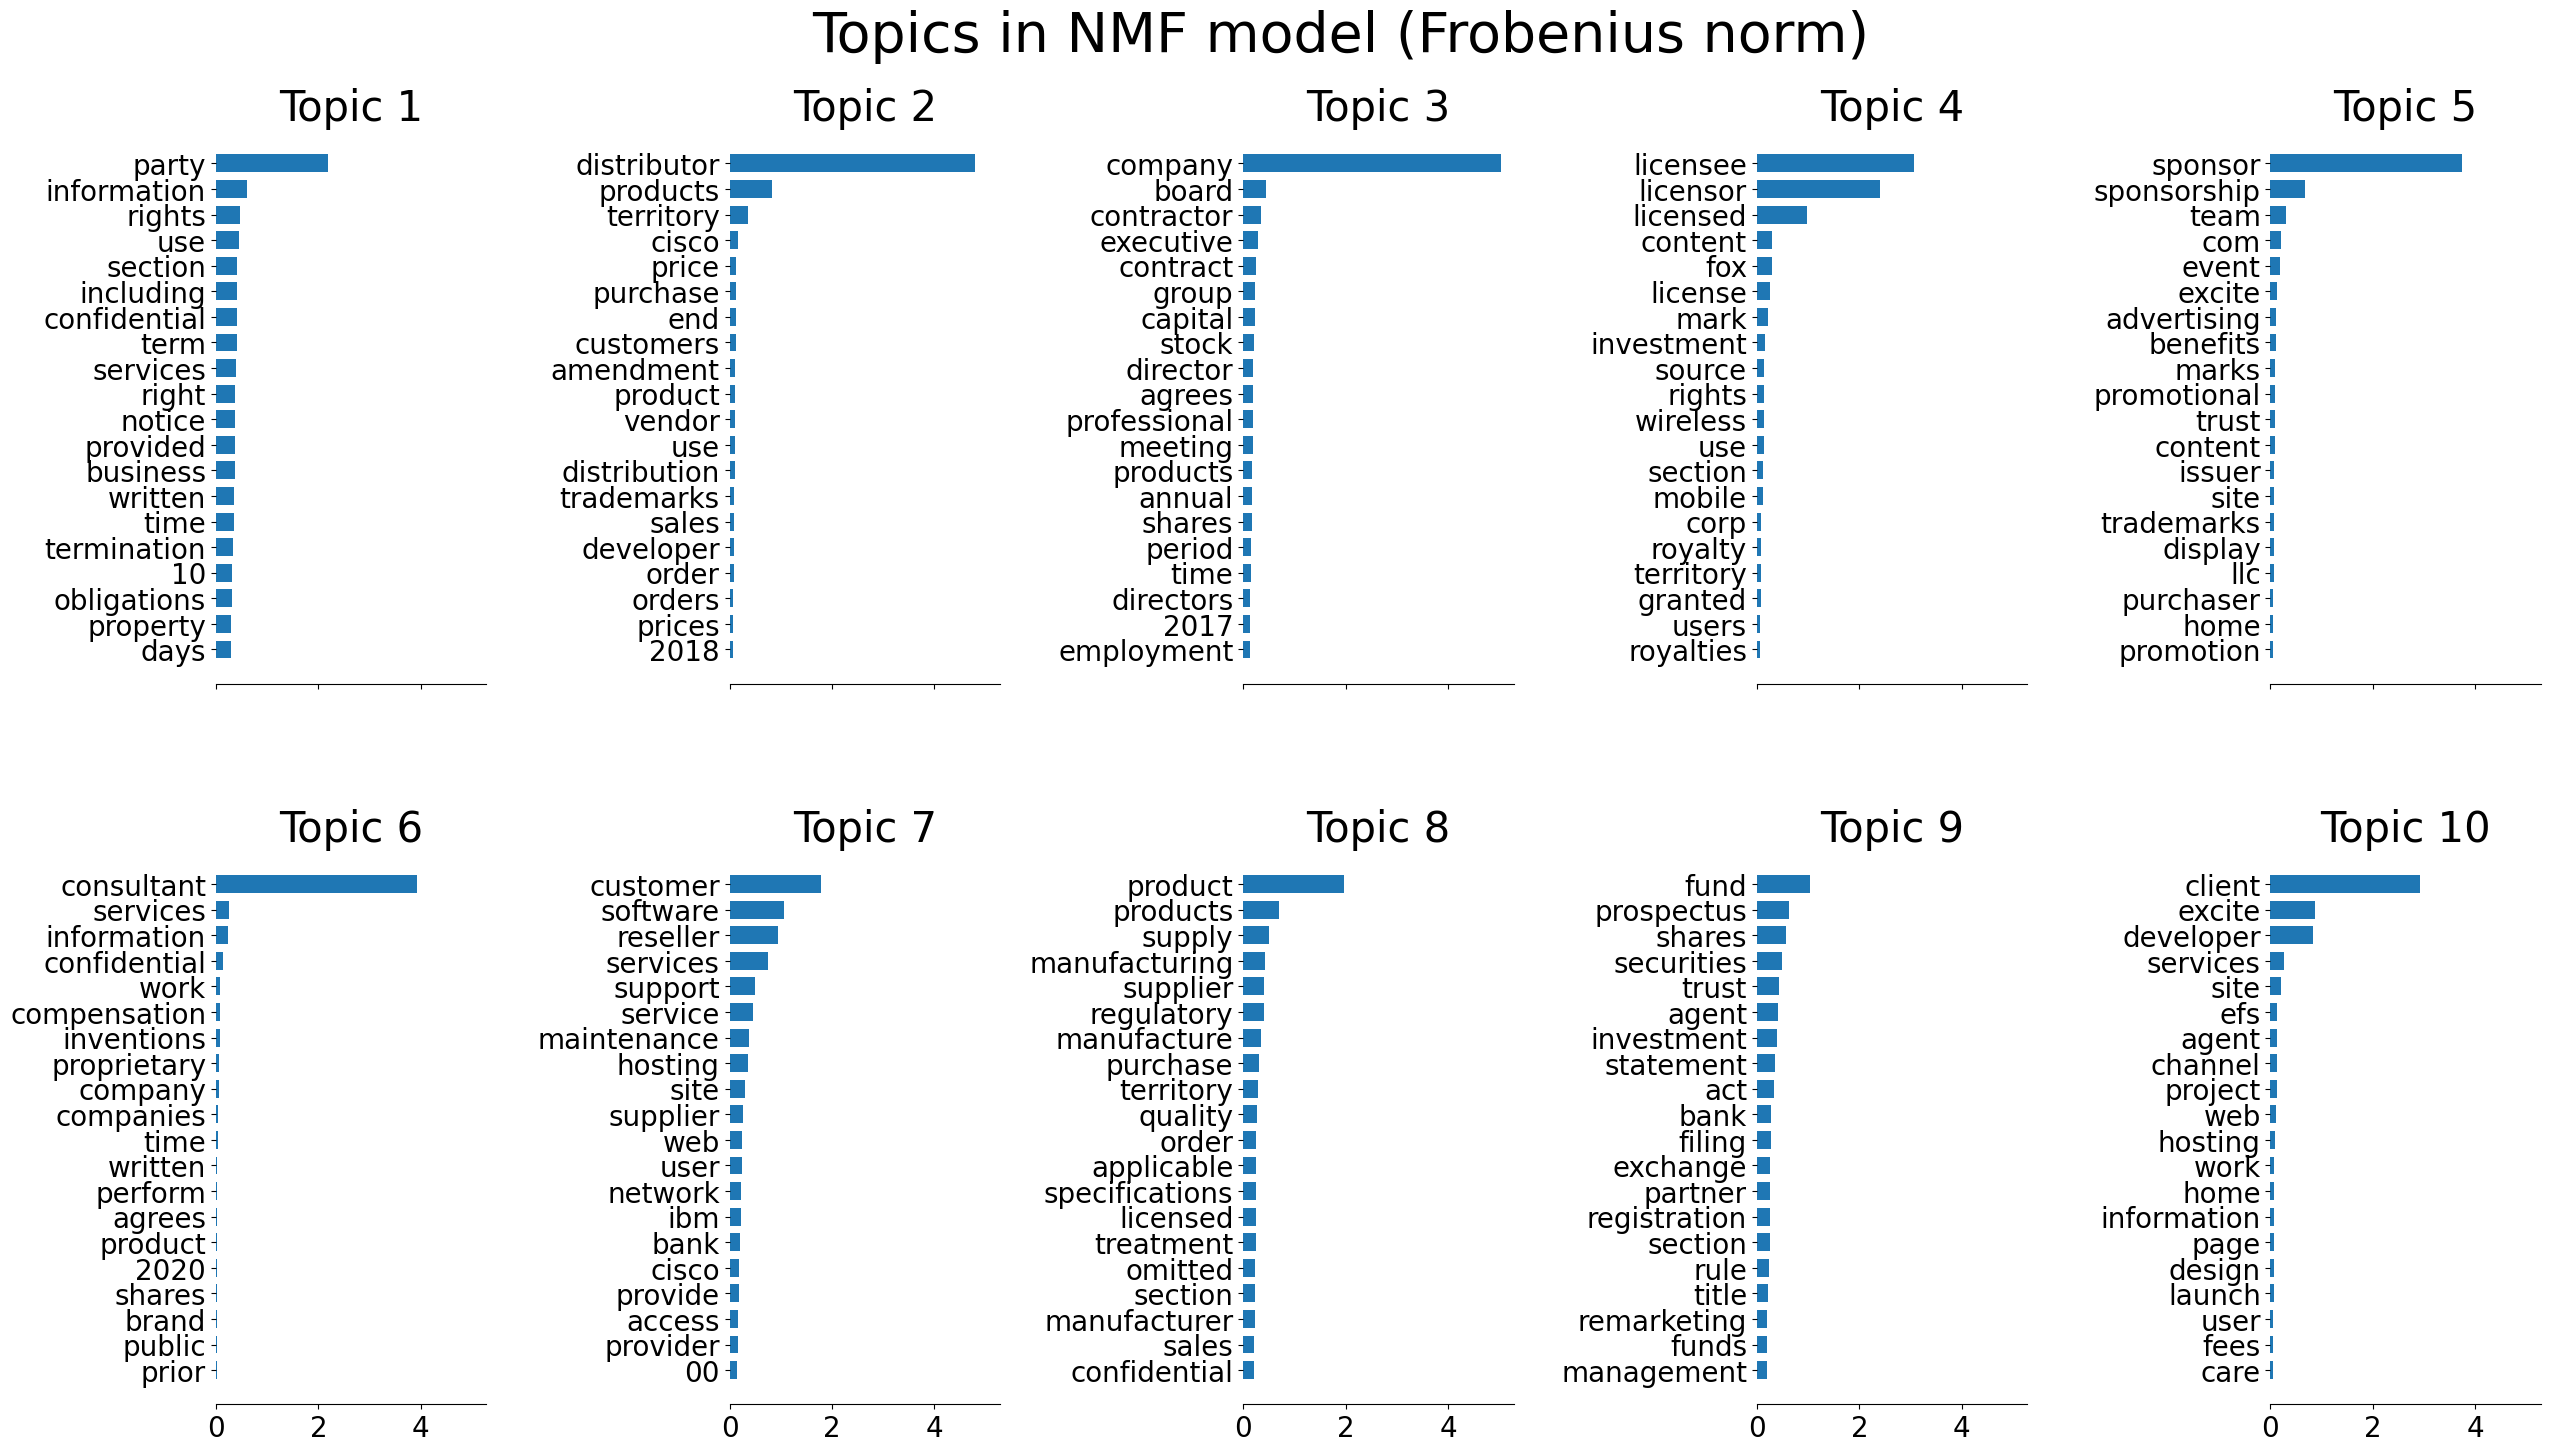



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_features=1000...
done in 3.946s.


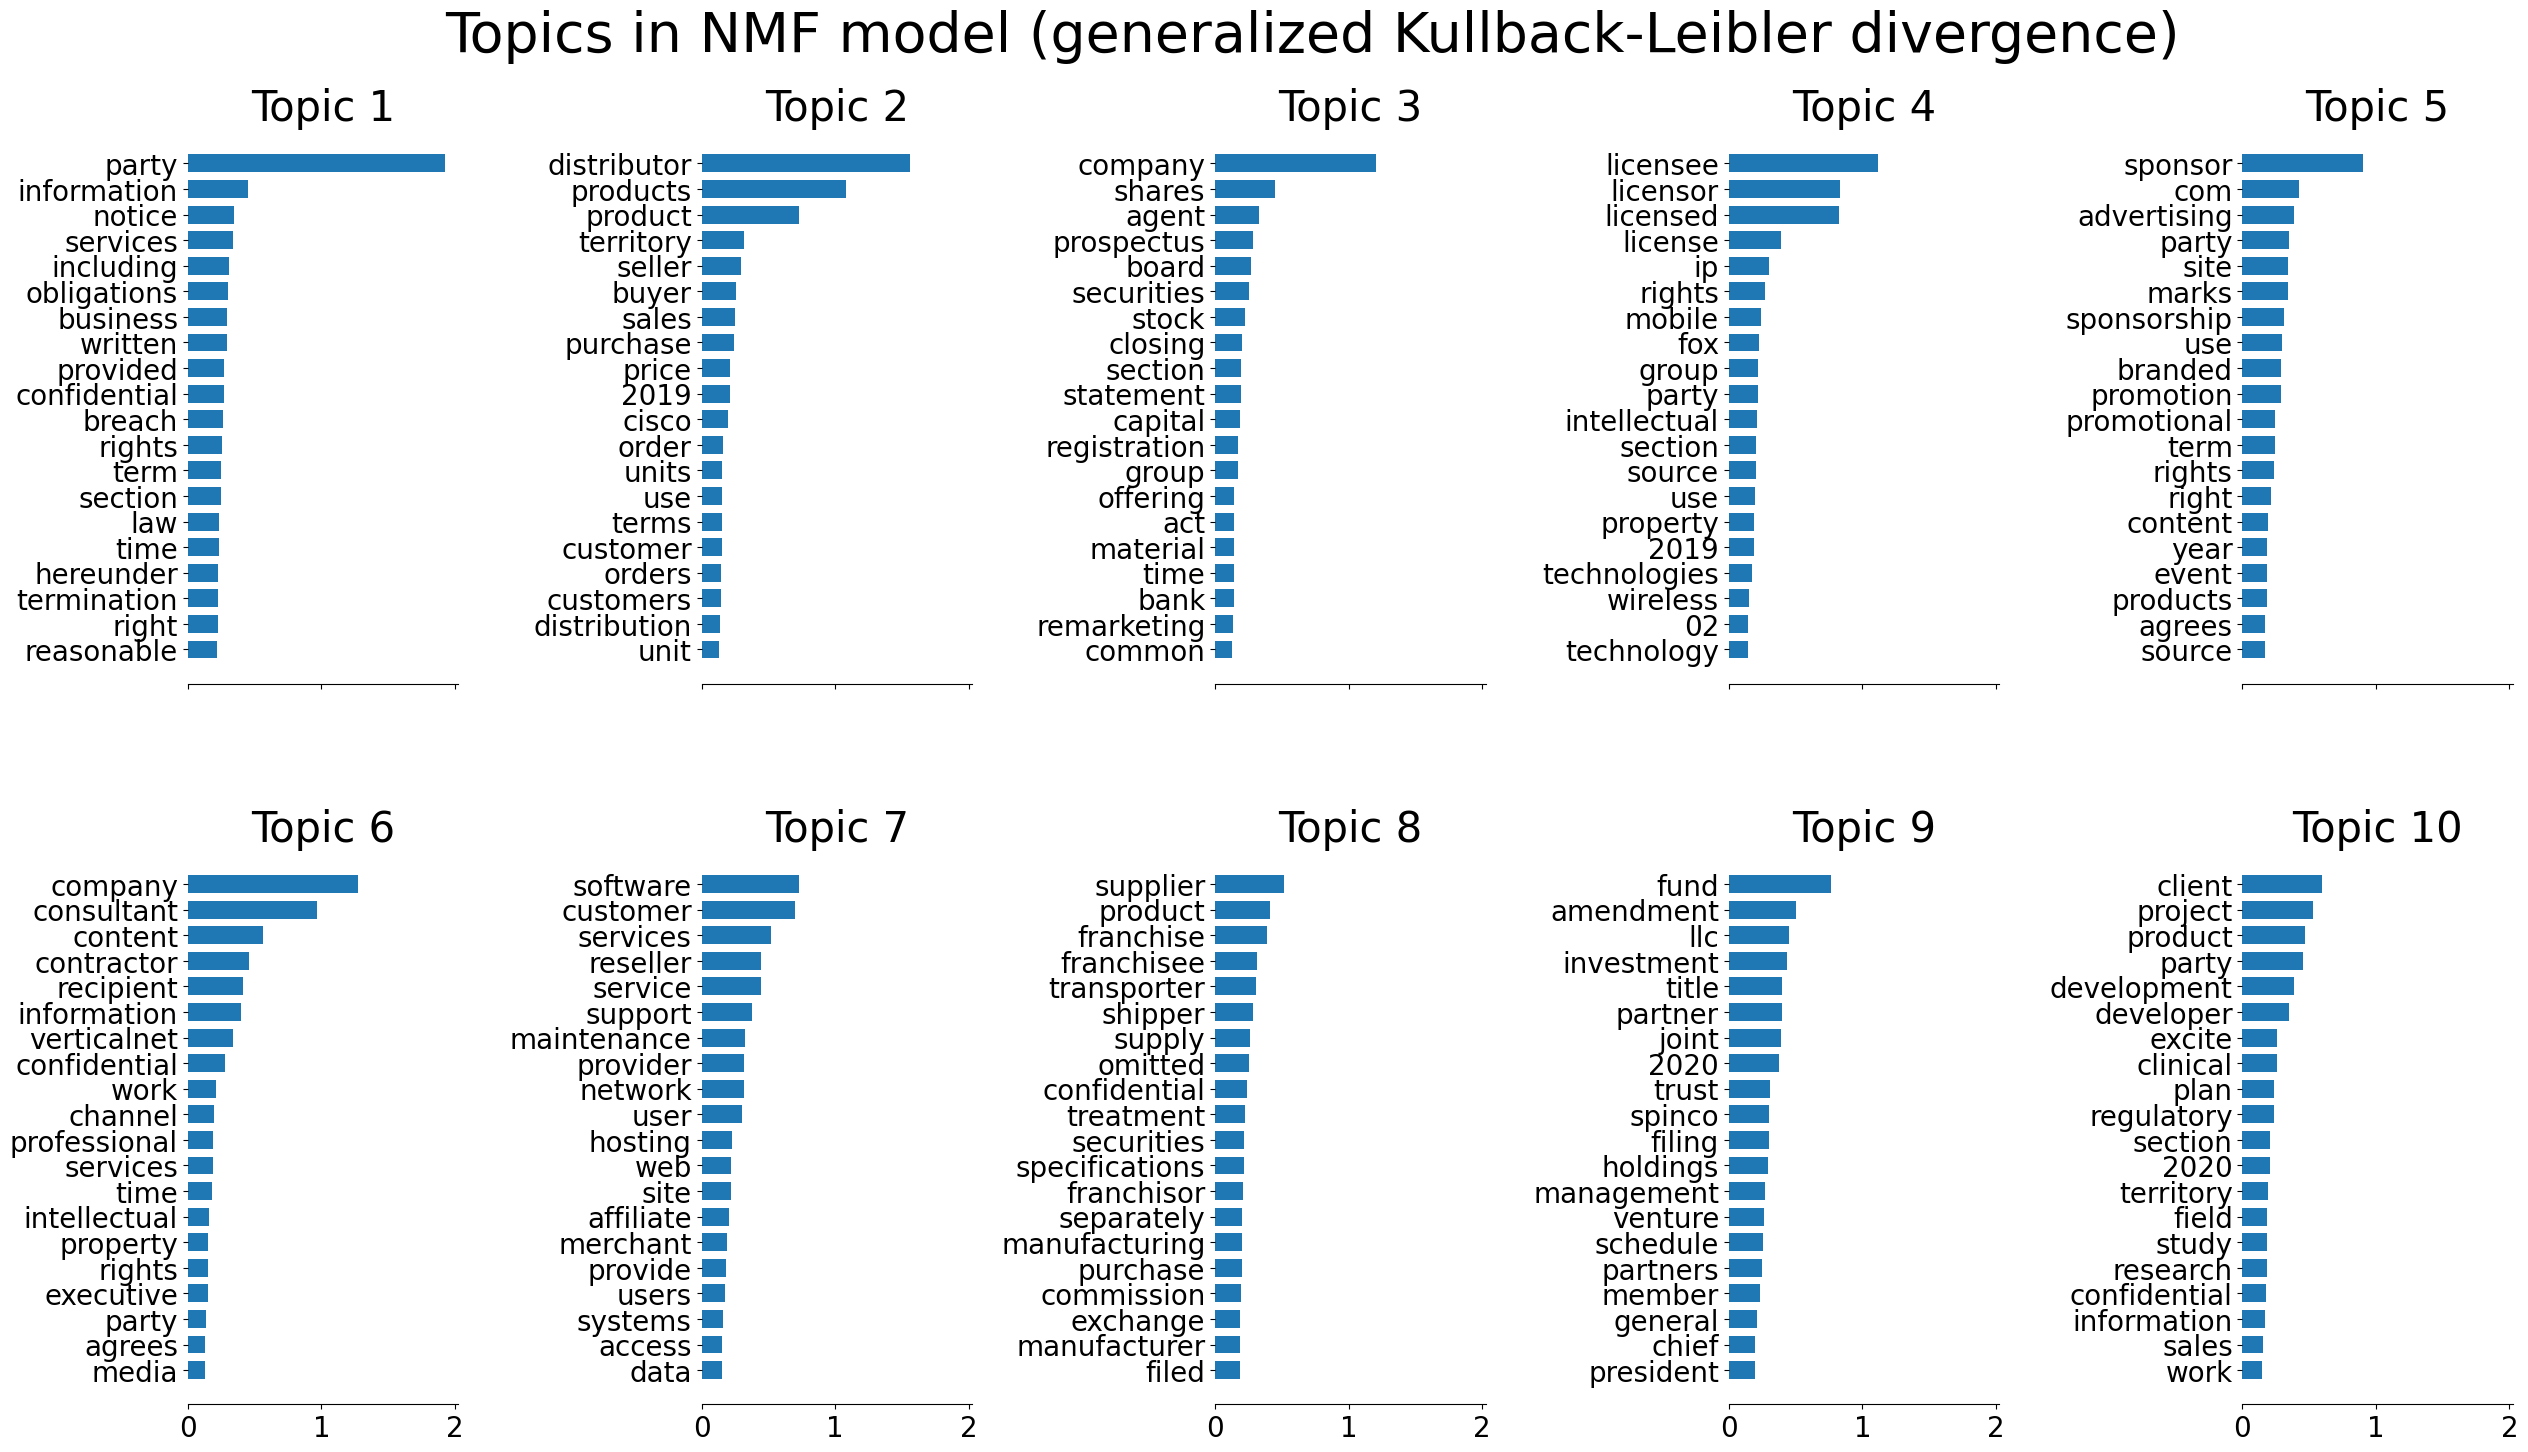



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_features=1000, batch_size=128...


/home/cethan/GitHub/542-LegalContract-AI/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:2328: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 7.316s.


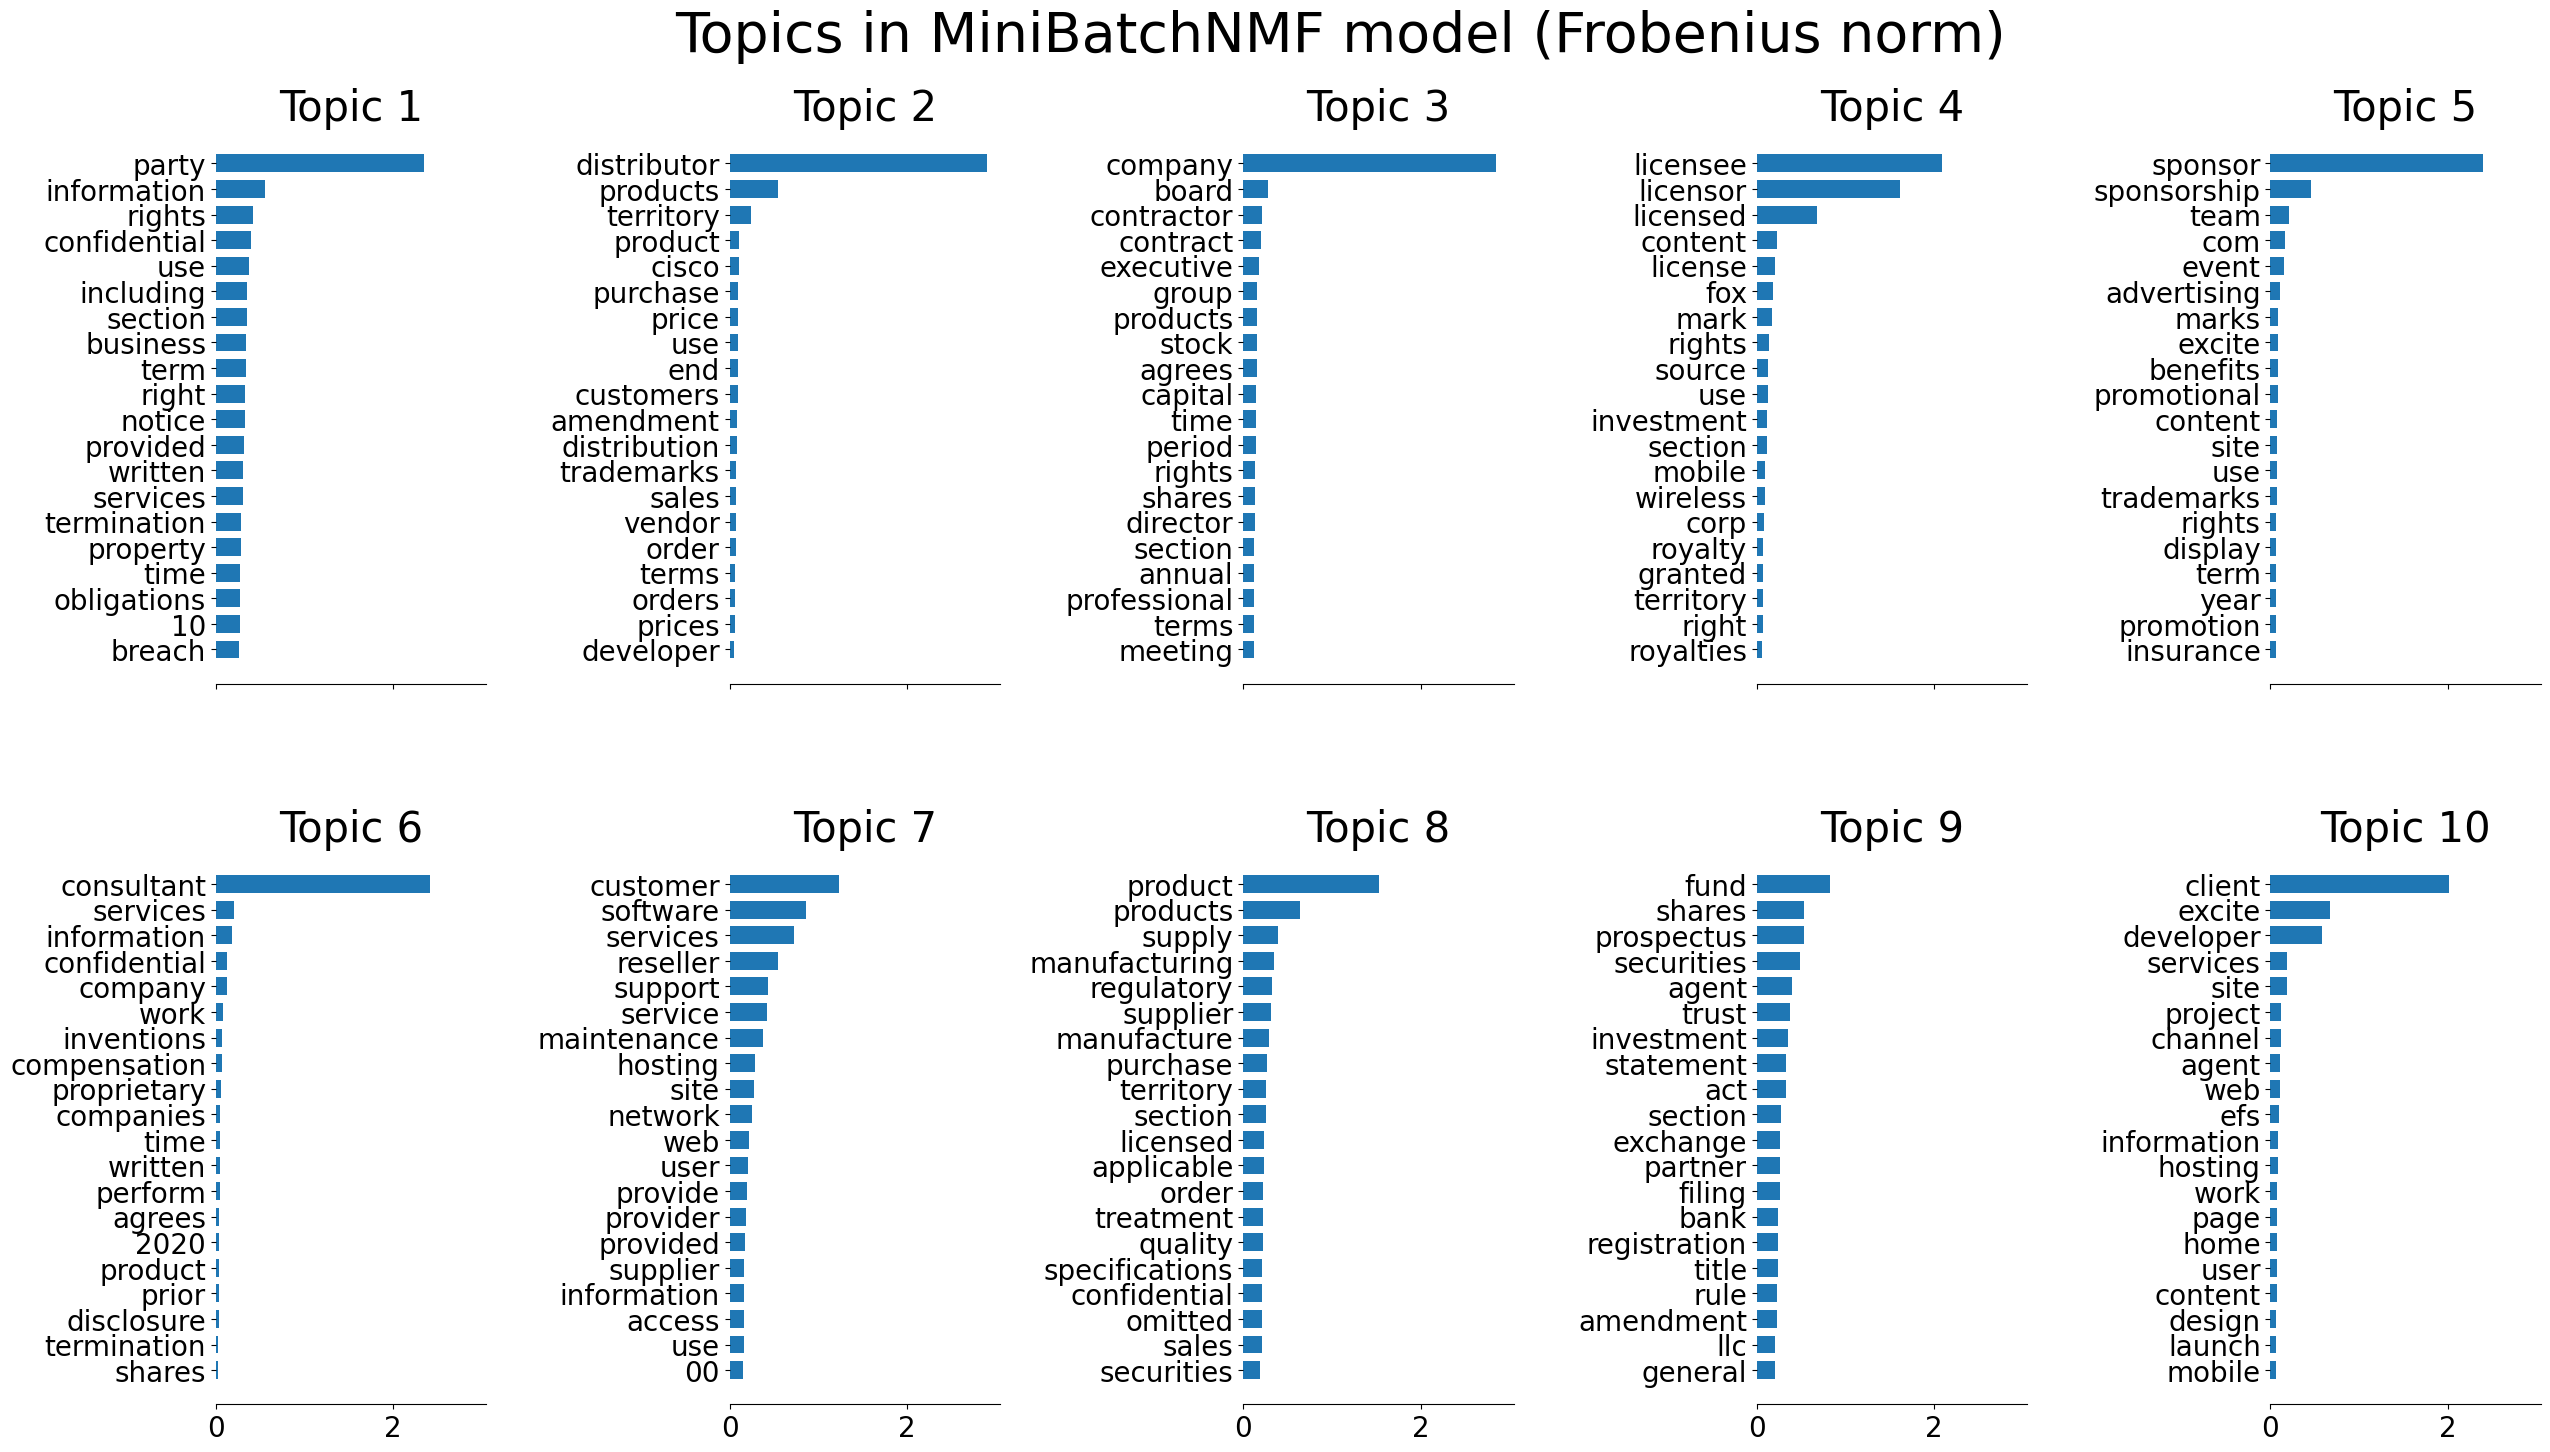



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features and n_features=1000, batch_size=128...
done in 18.764s.


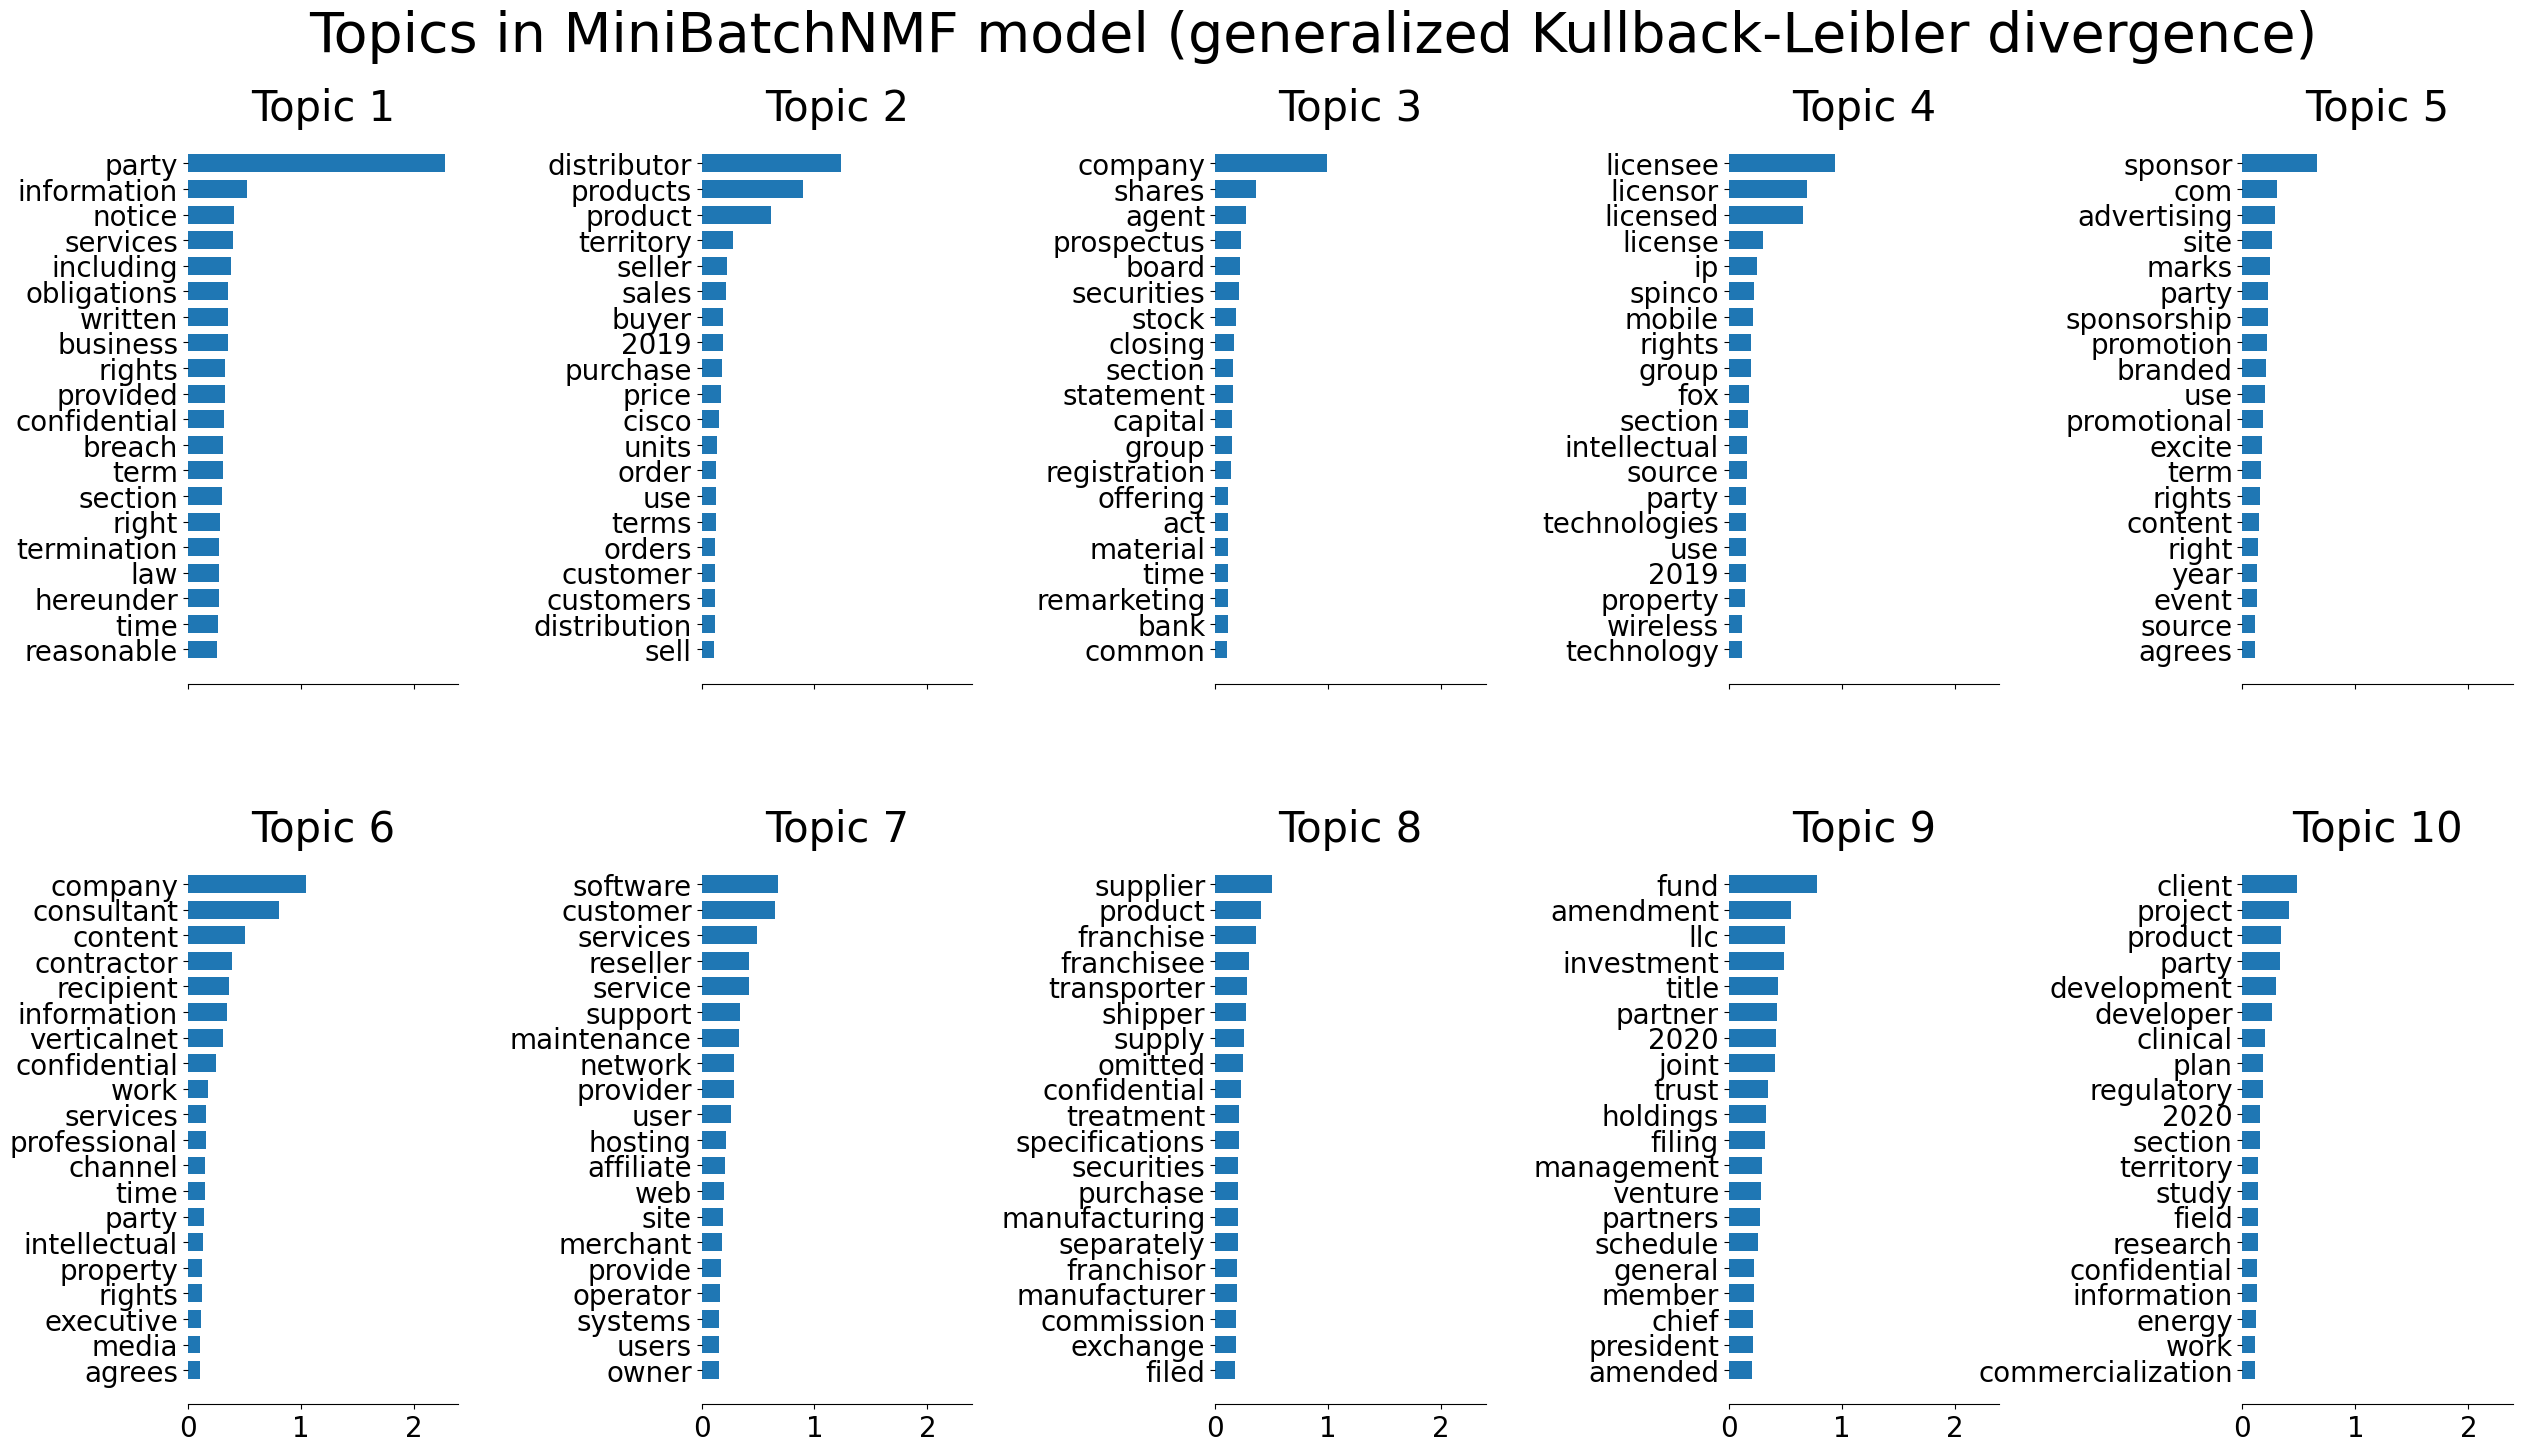



 Fitting LDA models with tf features and n_features=1000...
done in 1.700s.


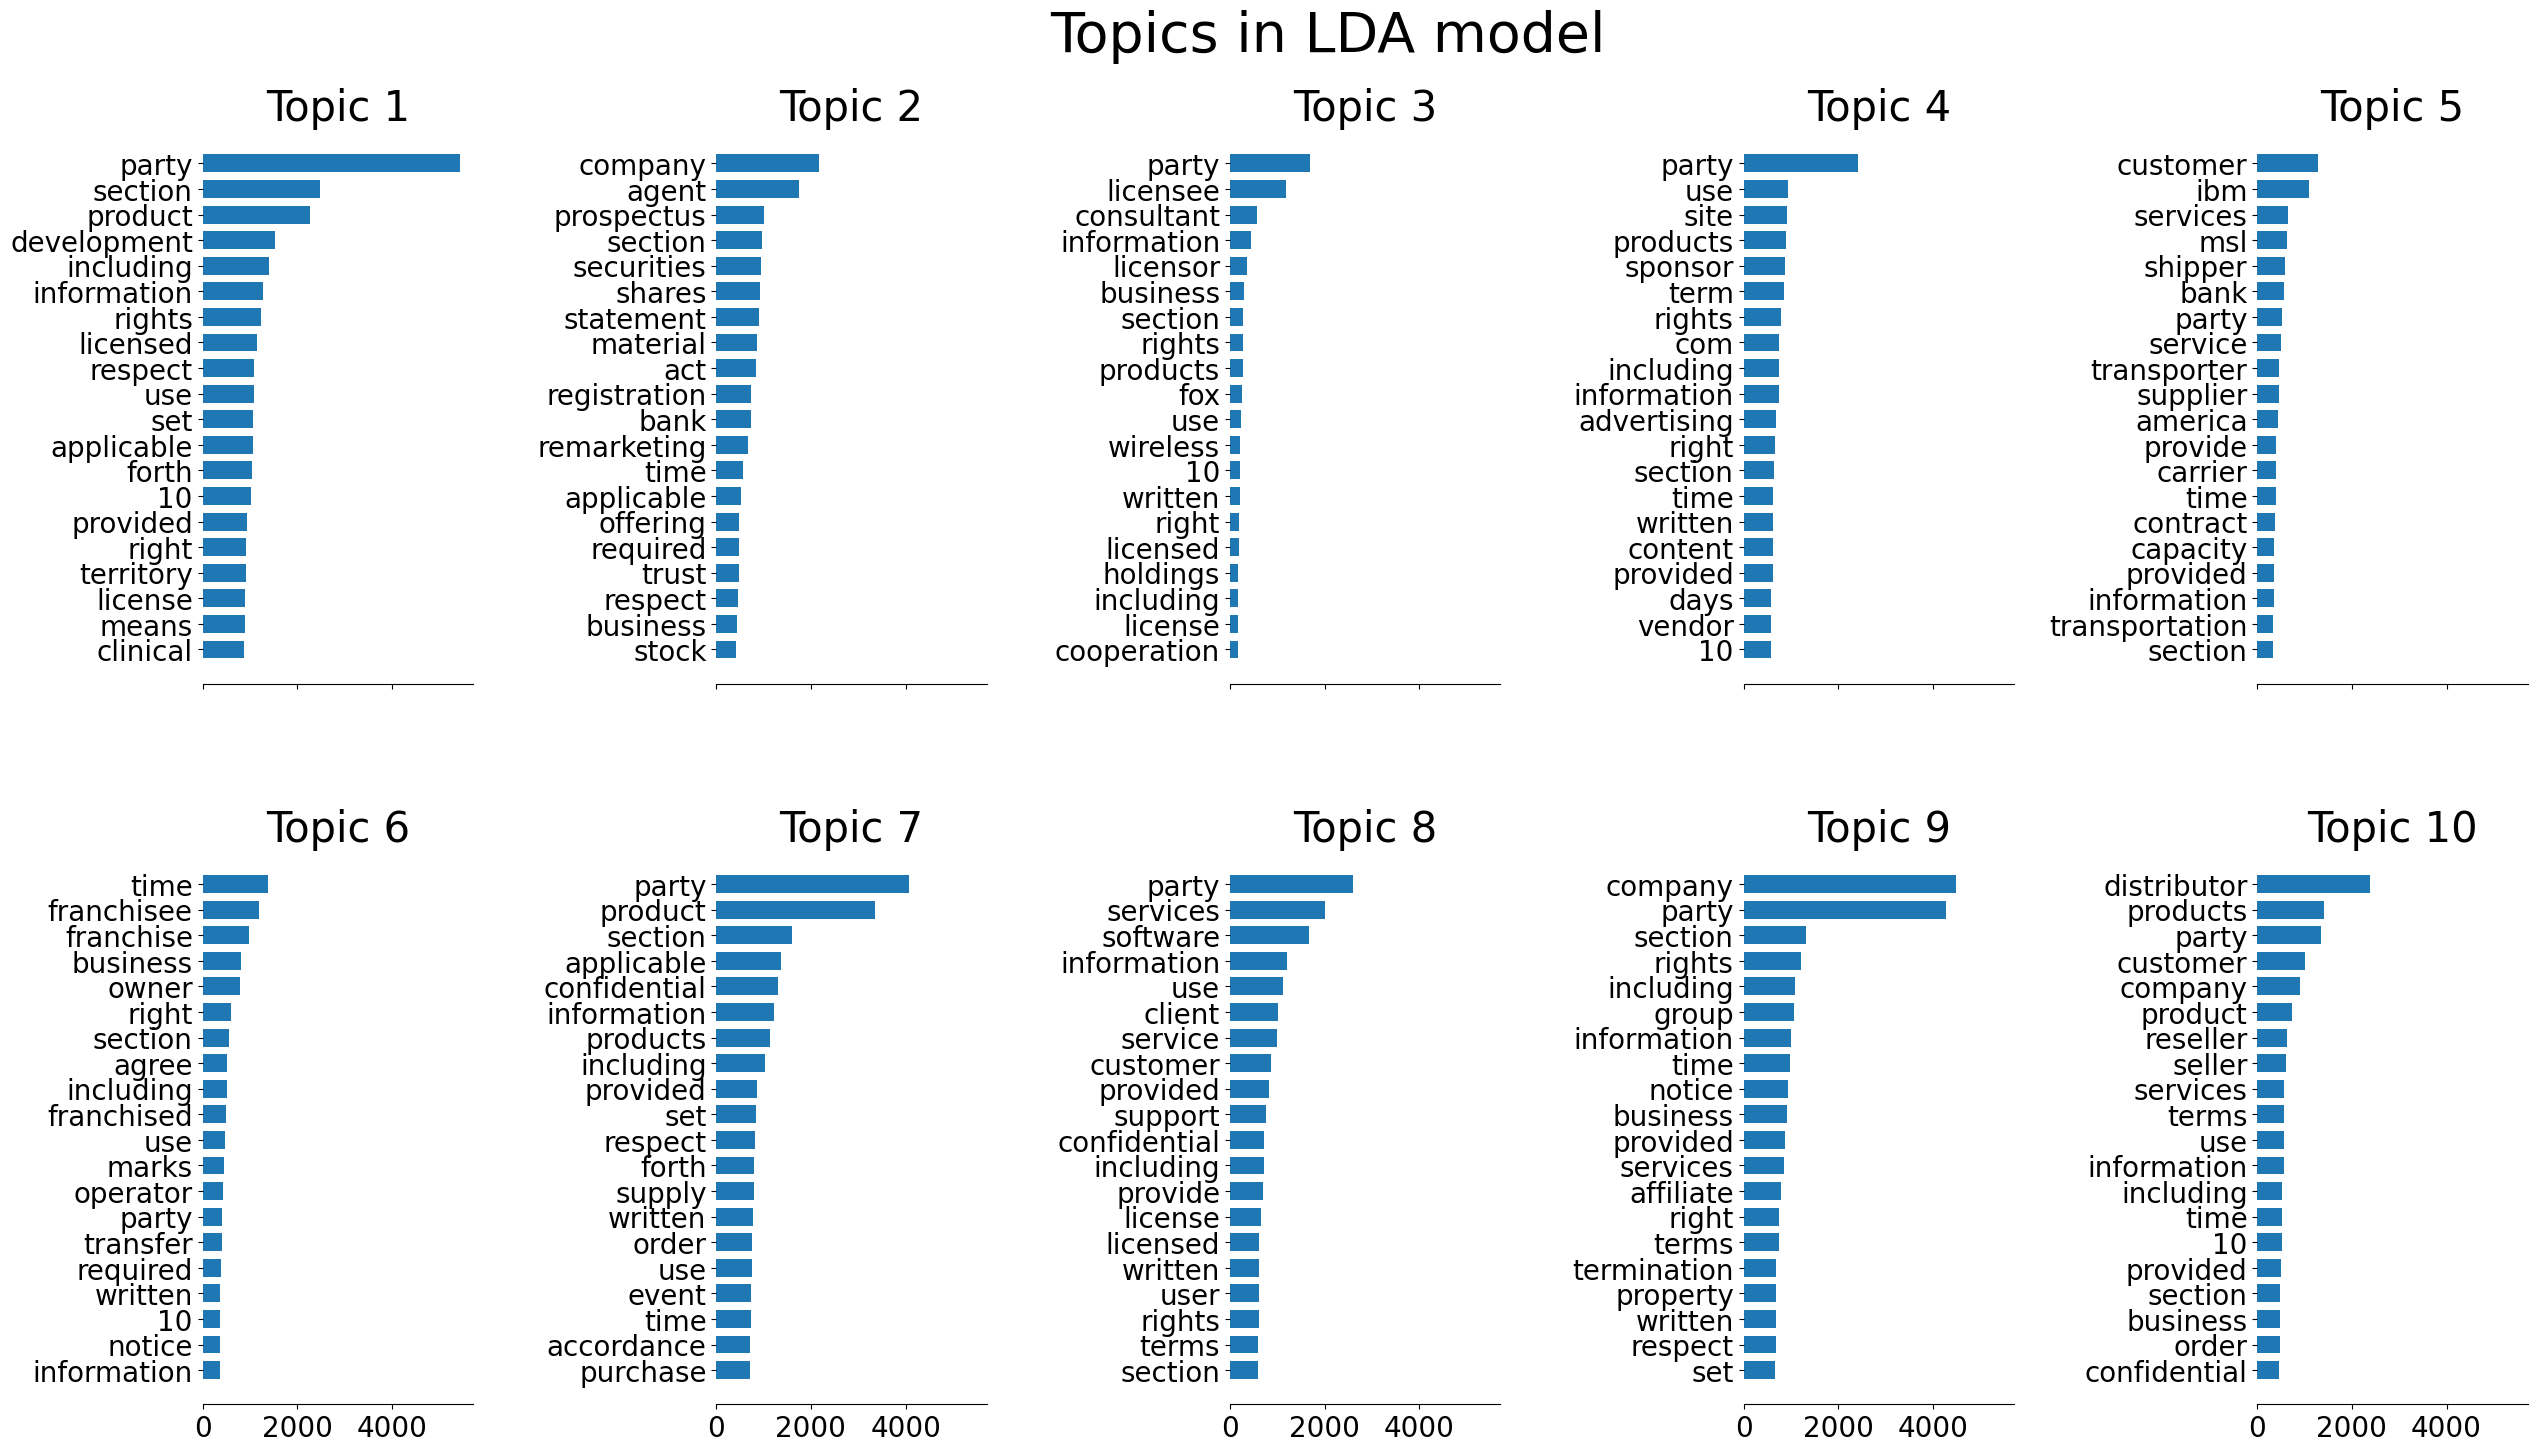

In [4]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    """Plot the top words for each topic in the model.

    Parameters
    ----------
    model : object
        The topic model (NMF, LDA, etc.) that contains the components_ attribute
    feature_names : array-like
        The names of the features (words) corresponding to each component
    n_top_words : int
        Number of top words to display for each topic
    title : str
        Title for the plot

    Returns
    -------
    None
        Displays a matplotlib figure with subplots for each topic

    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in ["top", "right", "left"]:
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

dataset = cuad_text

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
t0 = time()
tf = tf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    f"n_features={n_features}..."
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")

# Fit the NMF model
print(
    "\n" * 2,
    f"Fitting the NMF model (generalized Kullback-Leibler "
    f"divergence) with tf-idf features, n_features={n_features}..."
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    f"Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    f"features, n_features={n_features}, batch_size={batch_size}..."
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    f"Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    f"divergence) with tf-idf features and n_features={n_features}, "
    f"batch_size={batch_size}..."
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    f"Fitting LDA models with tf features and n_features={n_features}..."
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

## Contract NLI Only

Extracting tf-idf features for NMF...
done in 0.284s.
Extracting tf features for LDA...
done in 0.369s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_features=1000...


/home/cethan/GitHub/542-LegalContract-AI/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 0.413s.


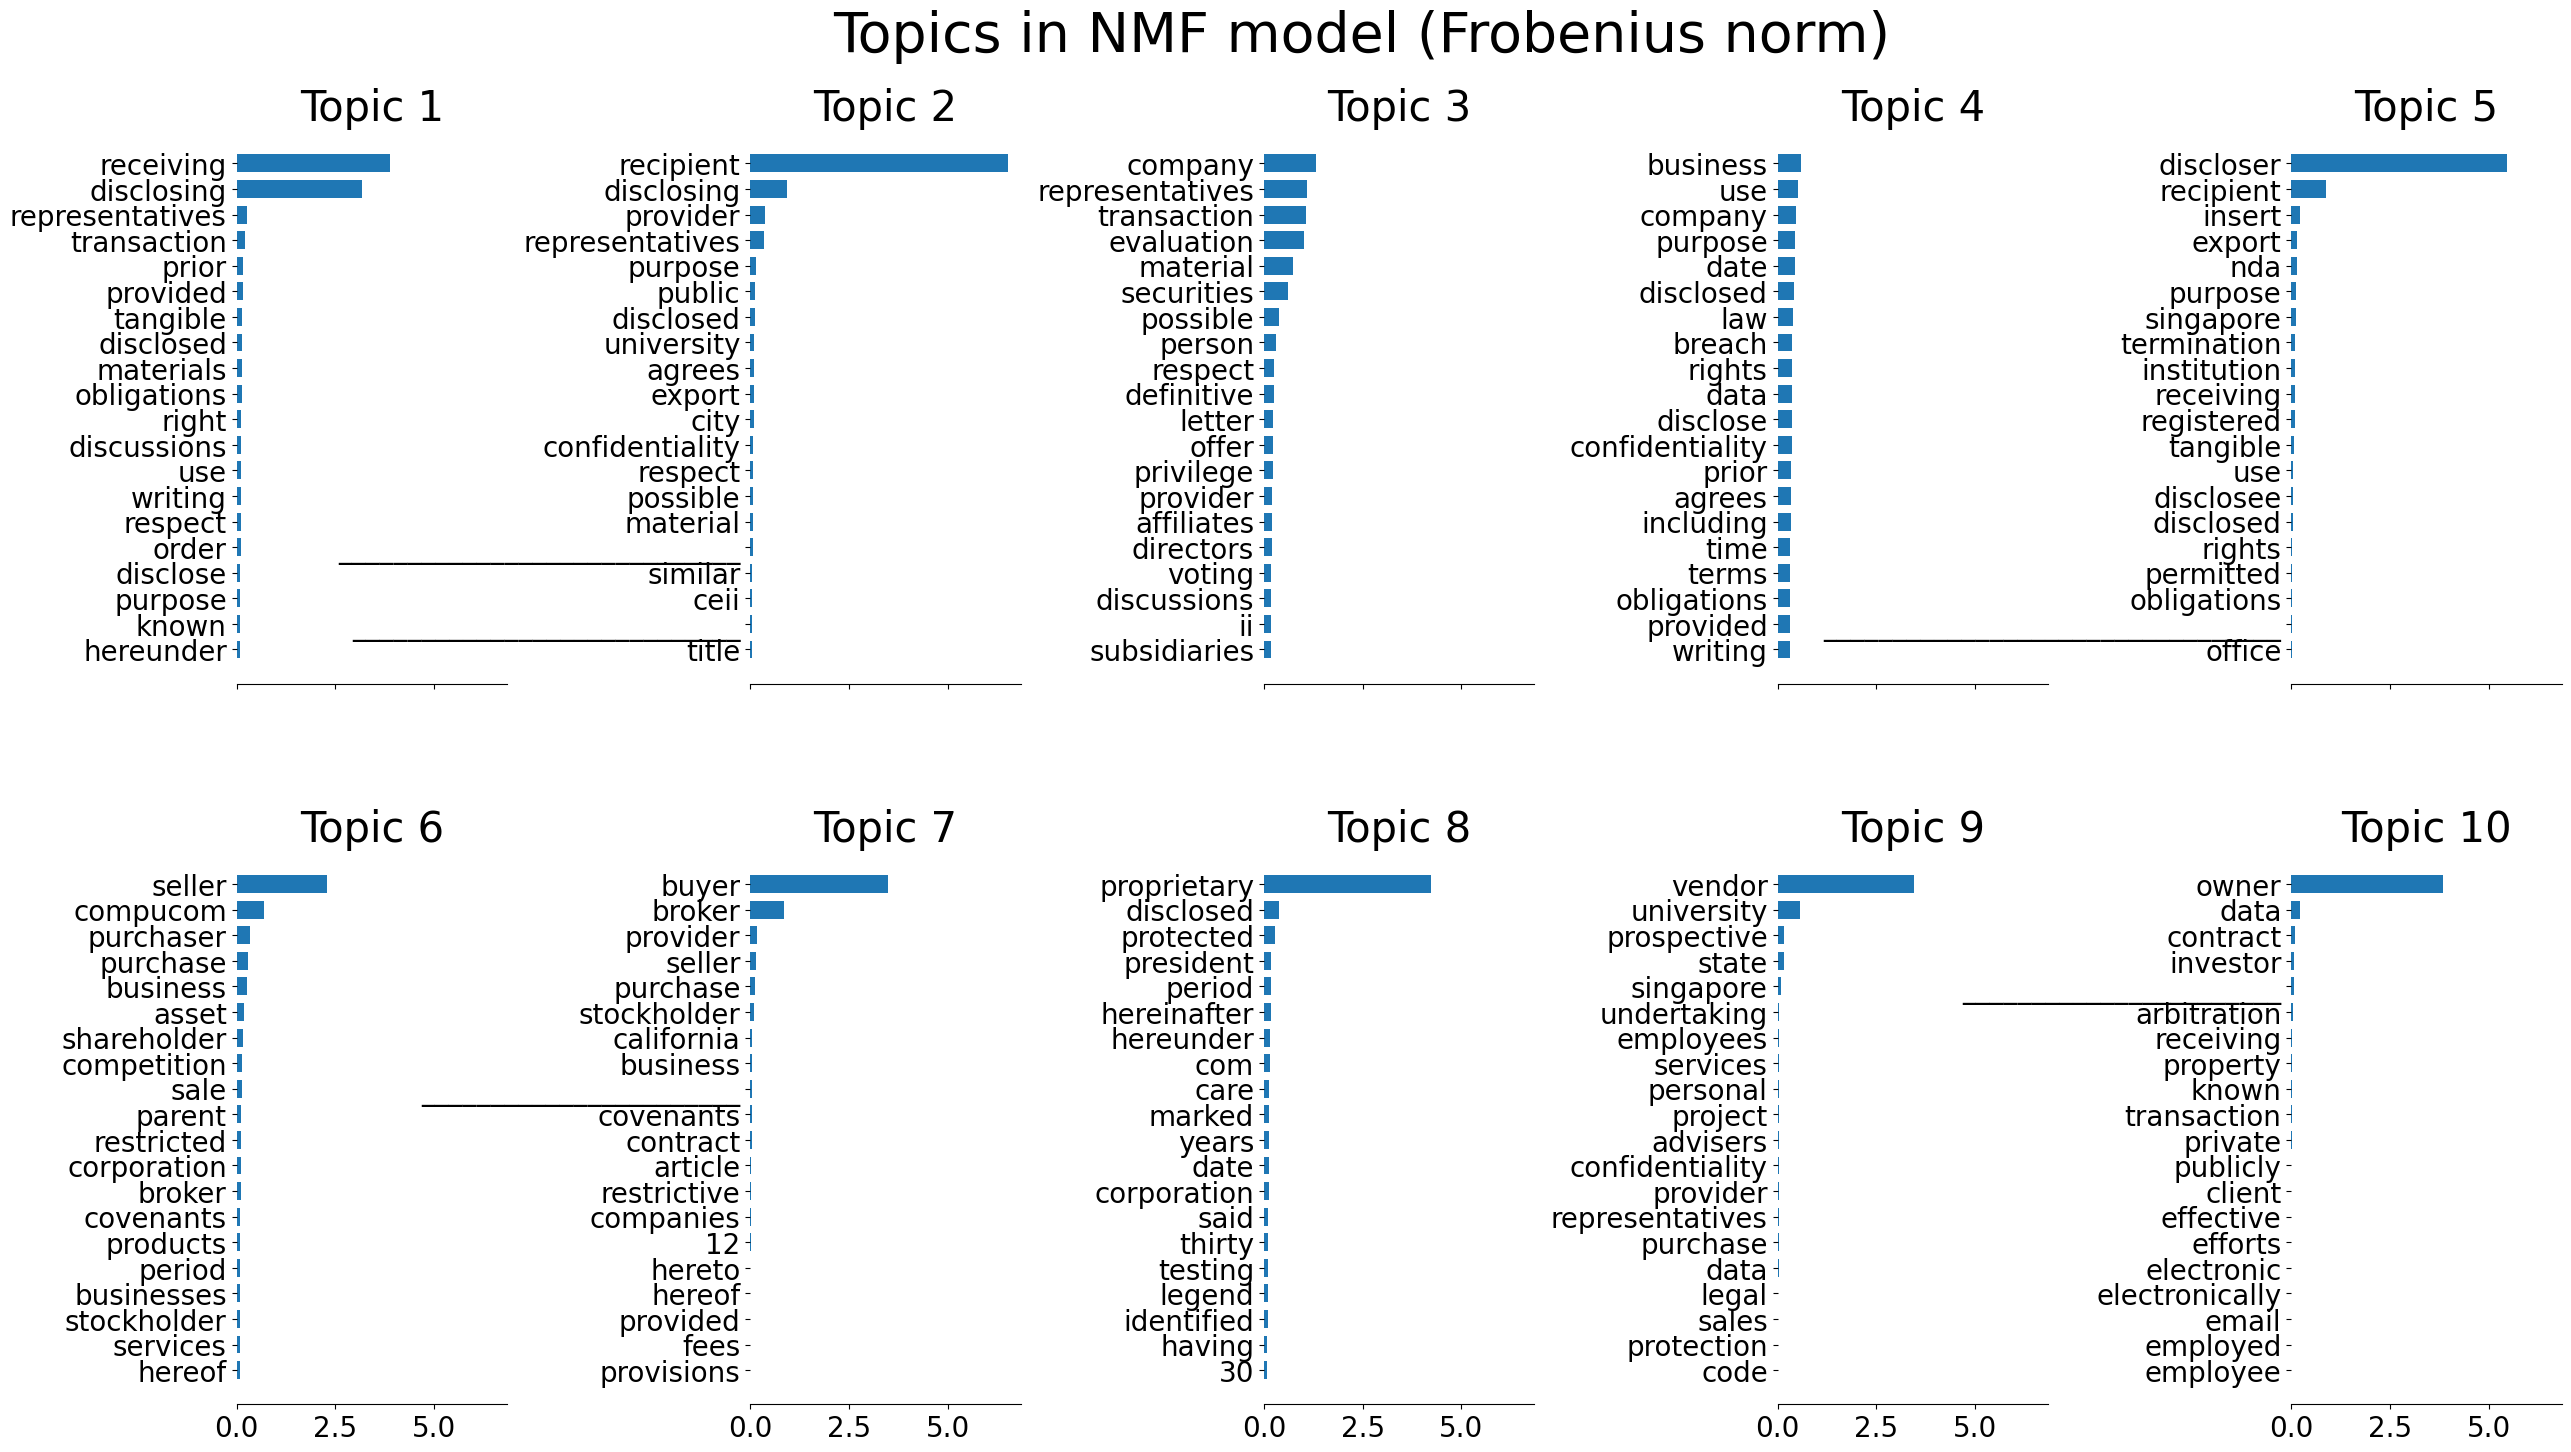



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_features=1000...
done in 5.308s.


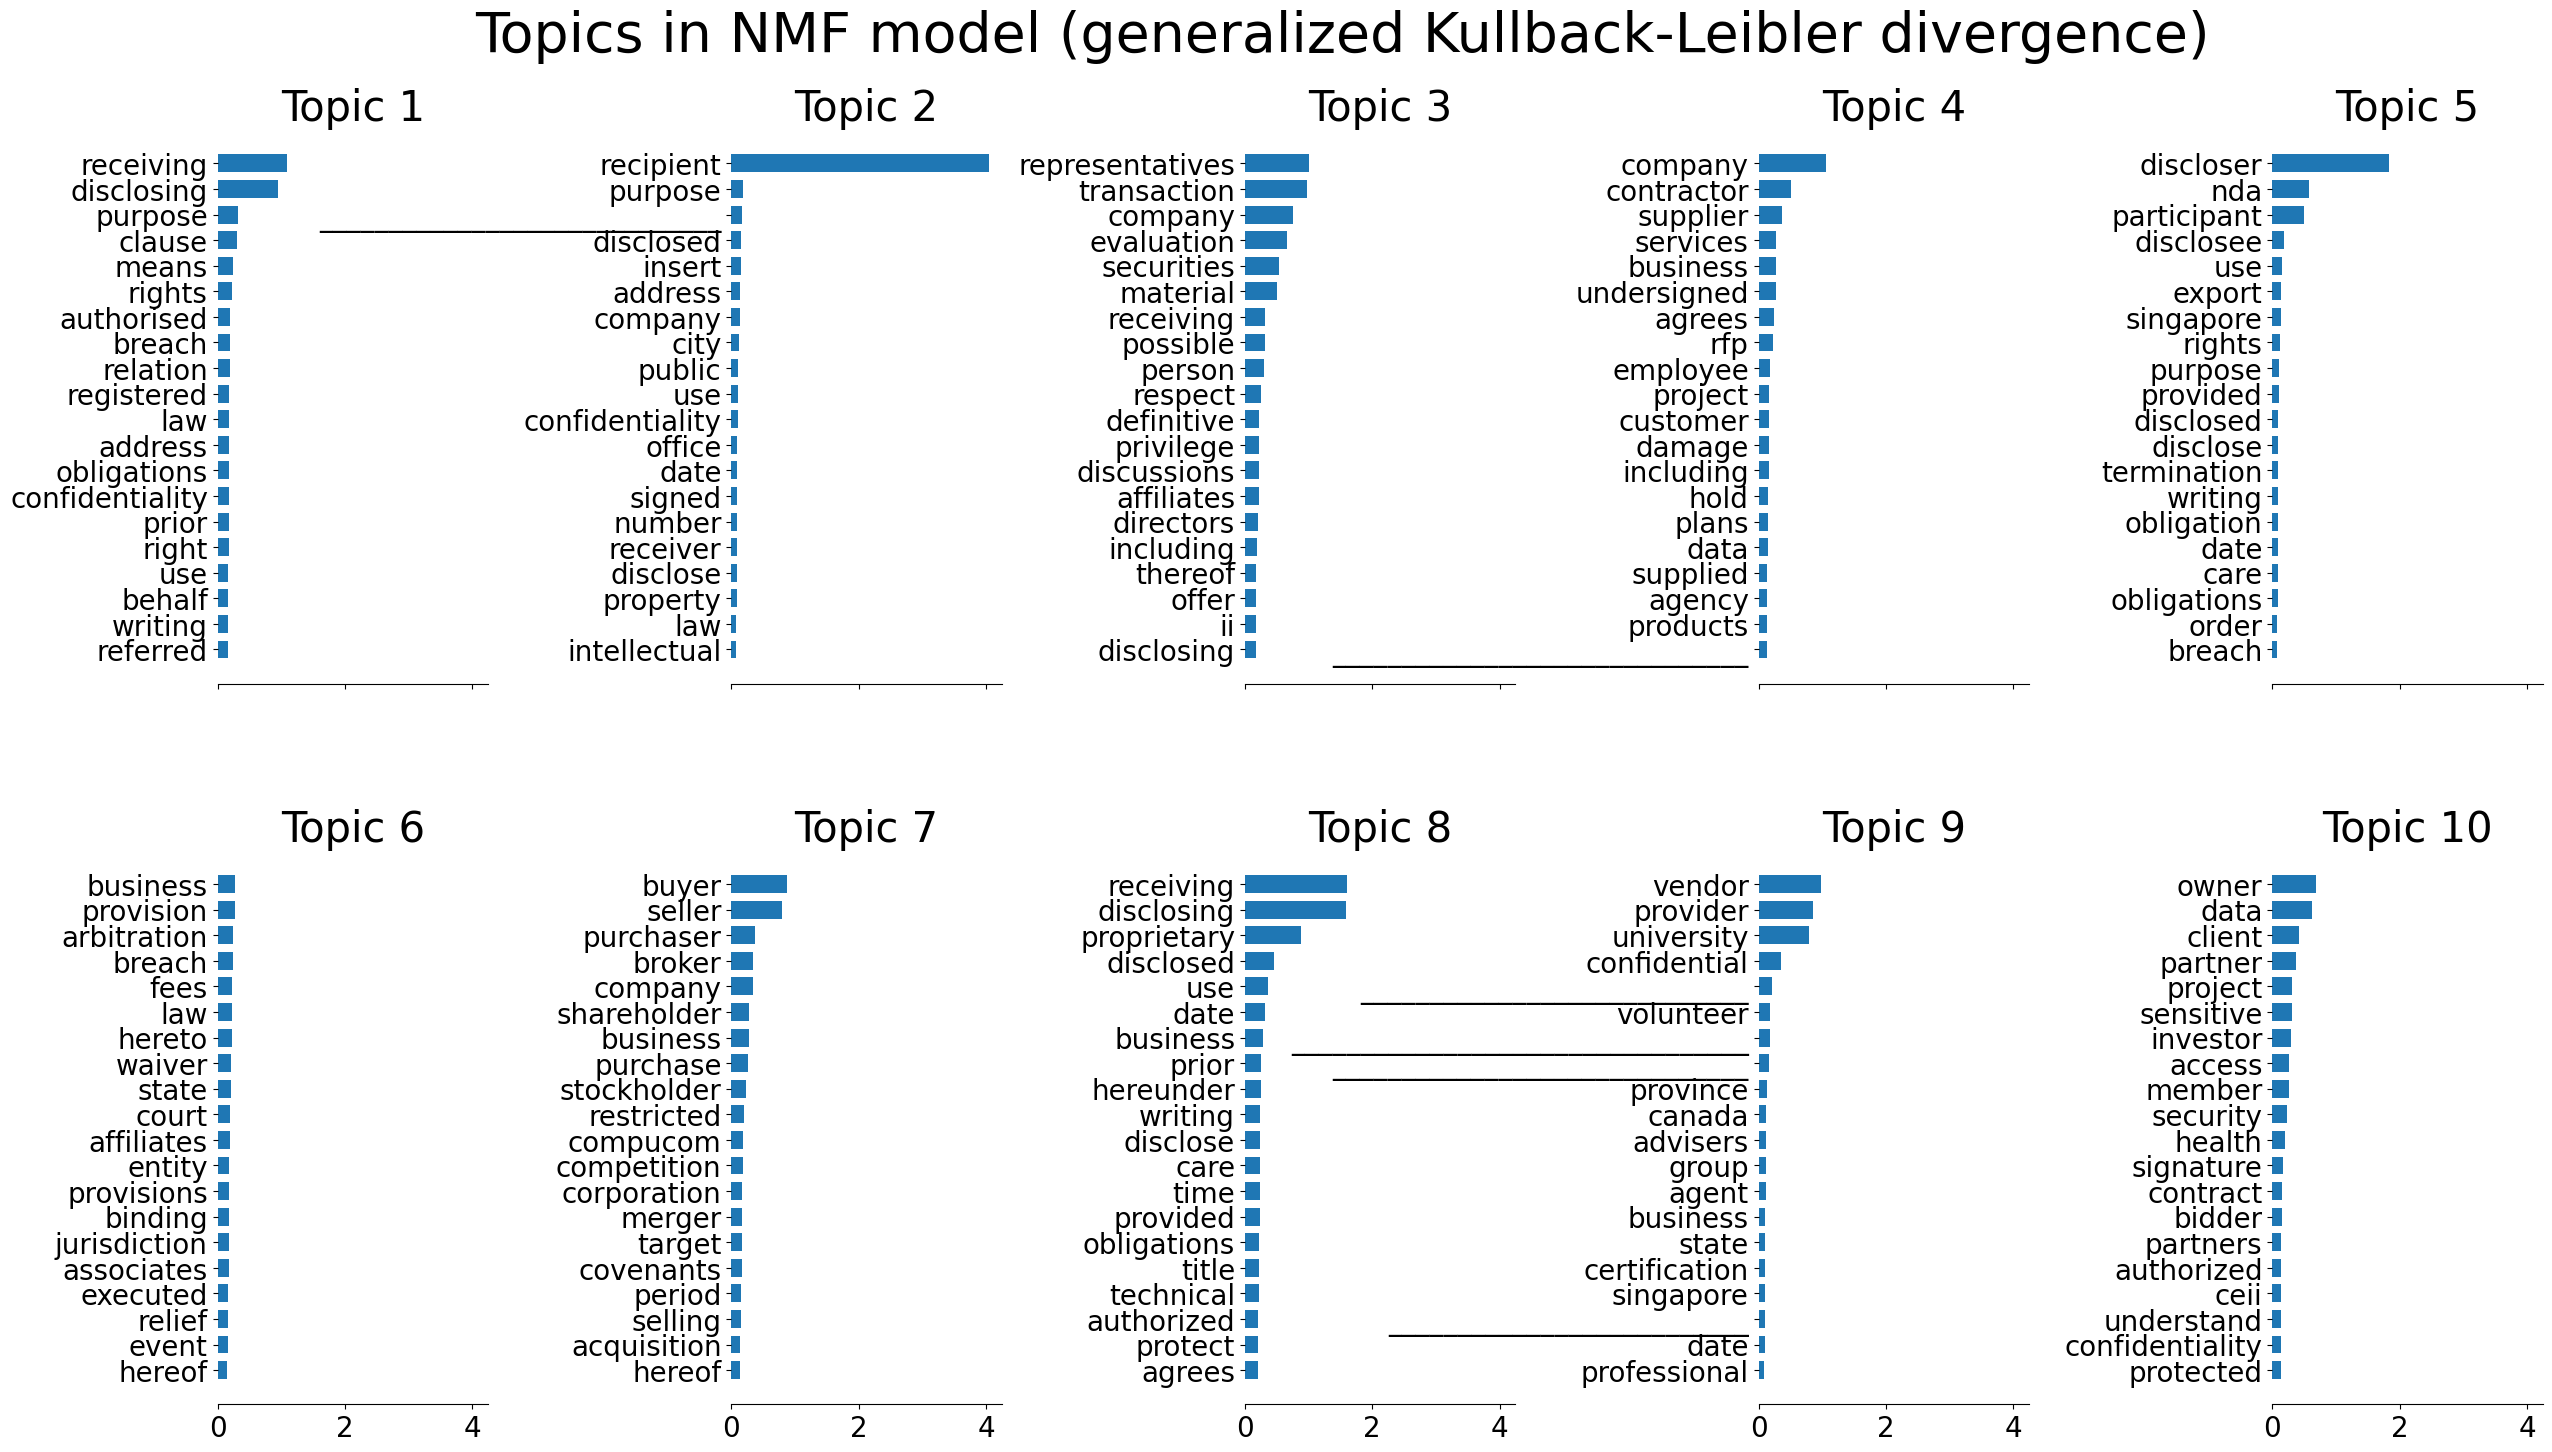



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_features=1000, batch_size=128...


/home/cethan/GitHub/542-LegalContract-AI/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:2328: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 11.801s.


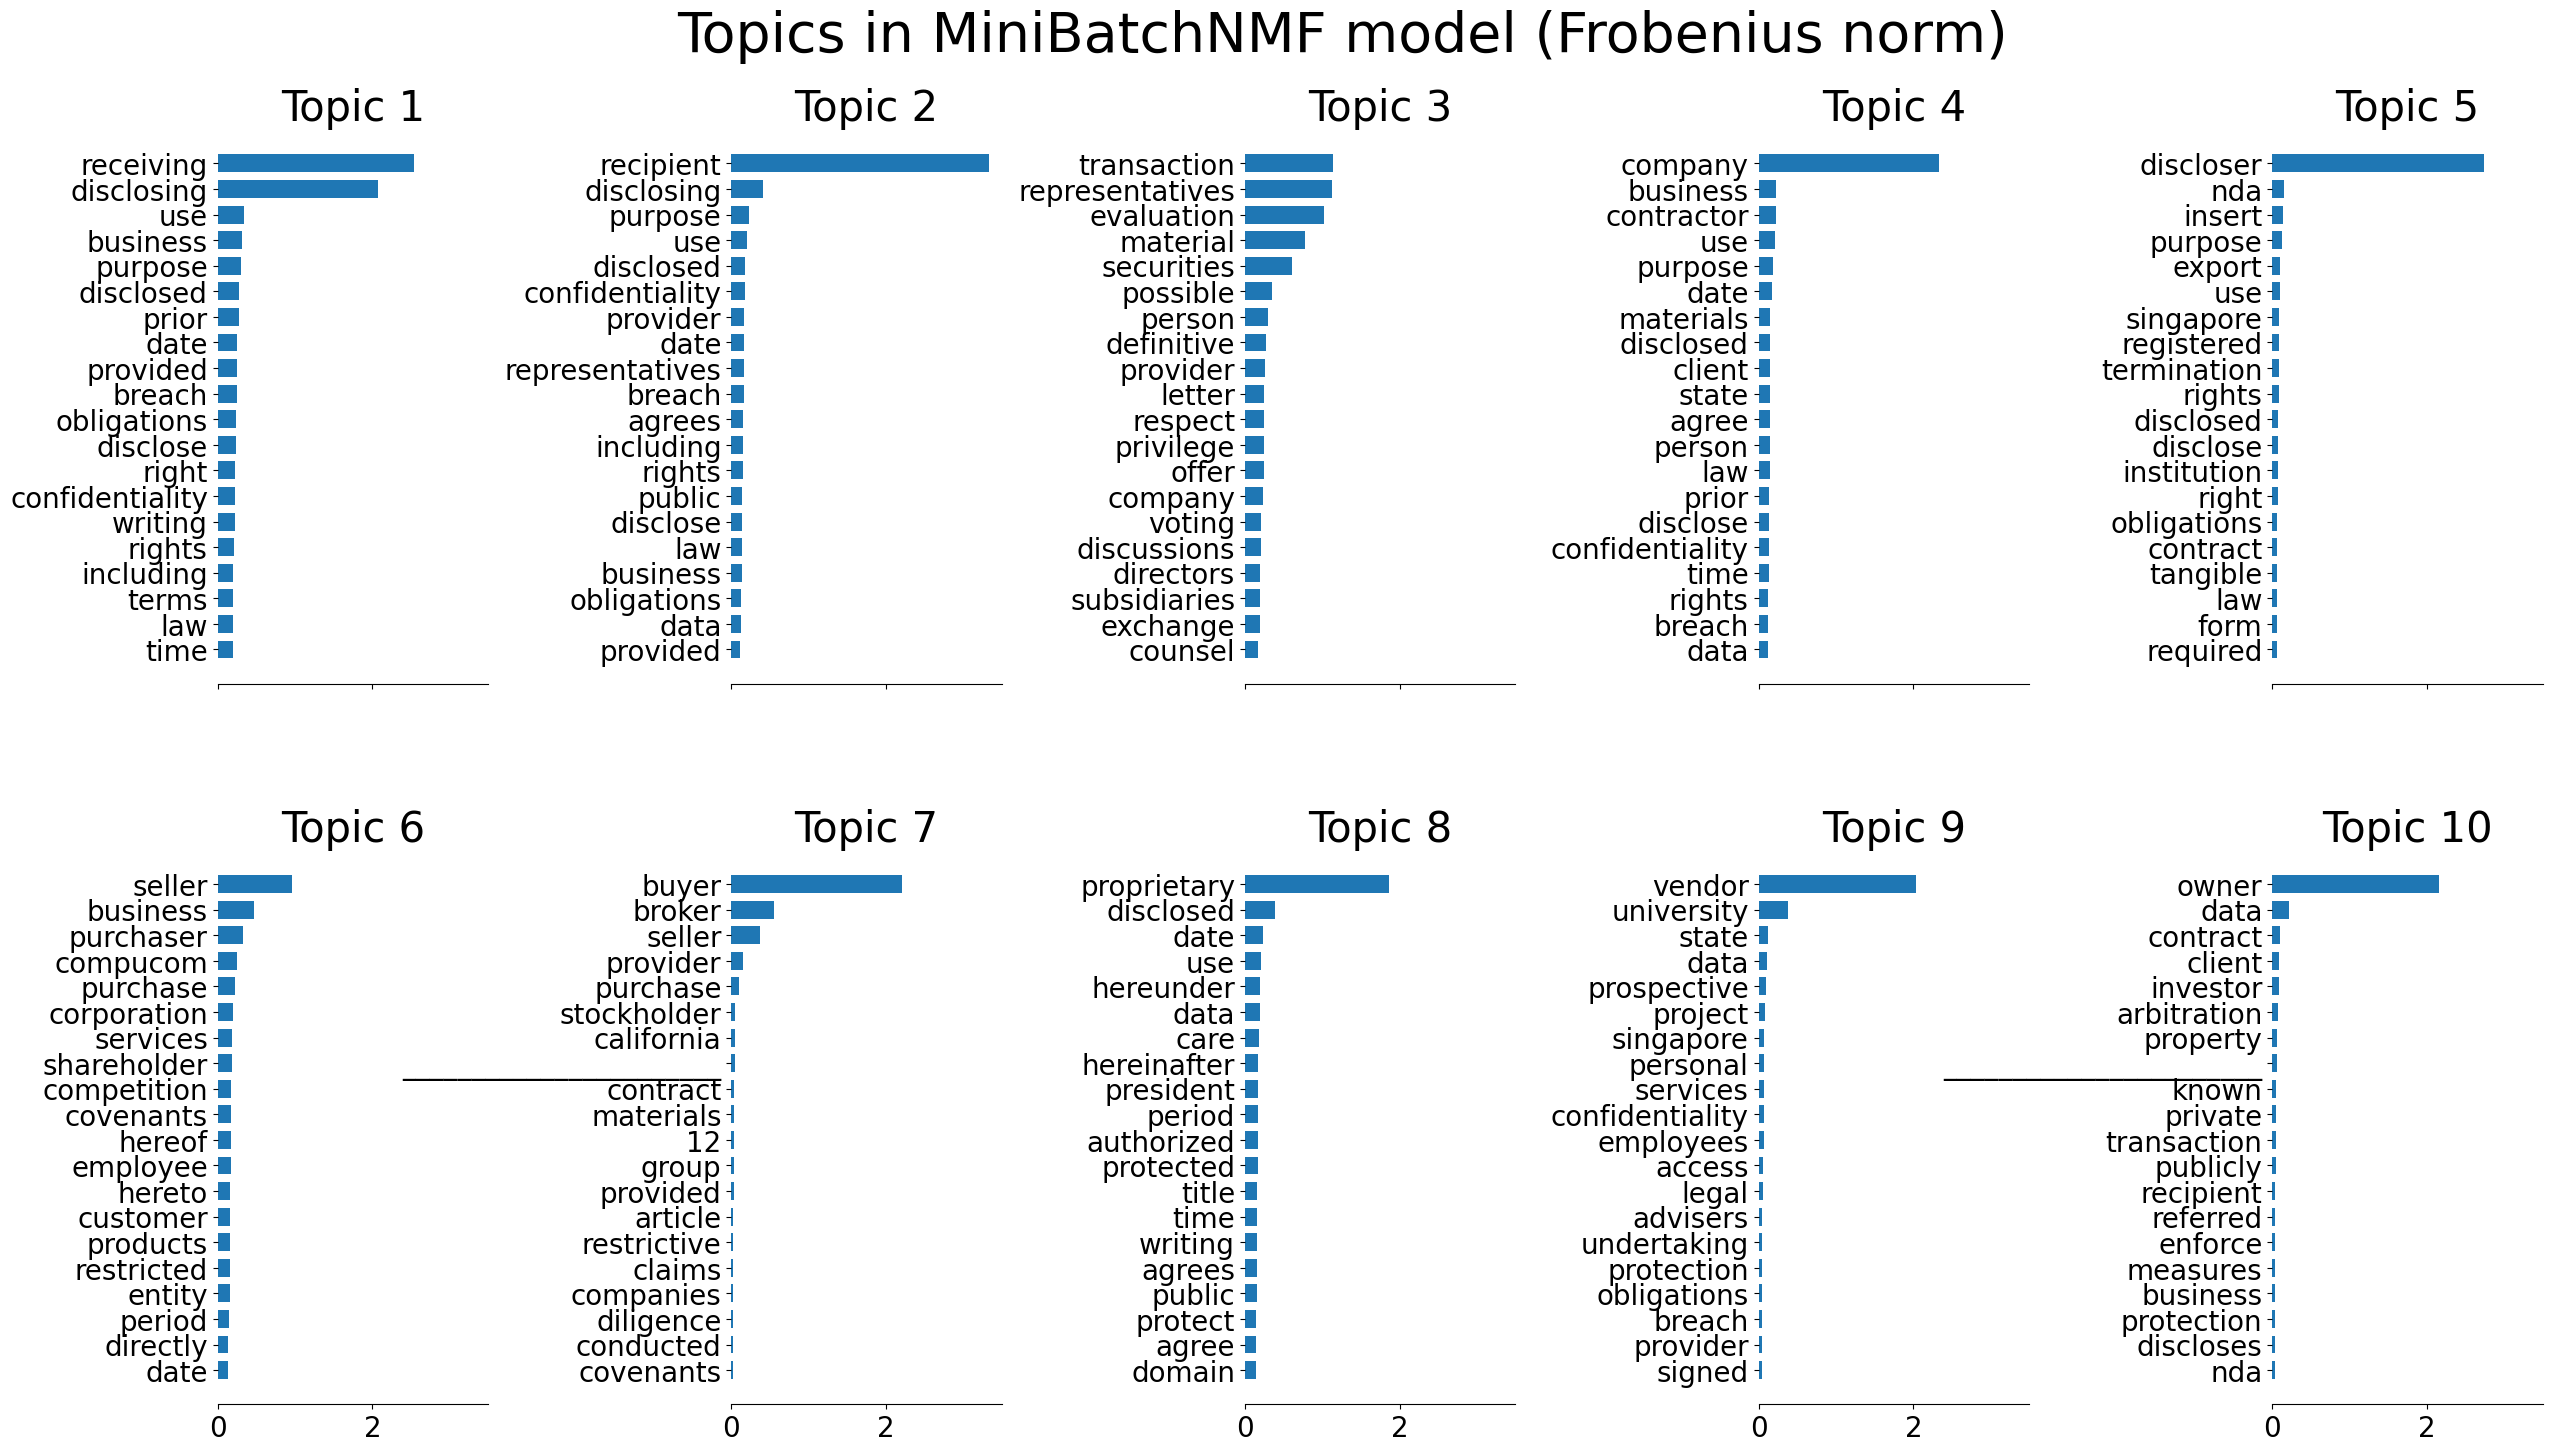



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features and n_features=1000, batch_size=128...
done in 19.810s.


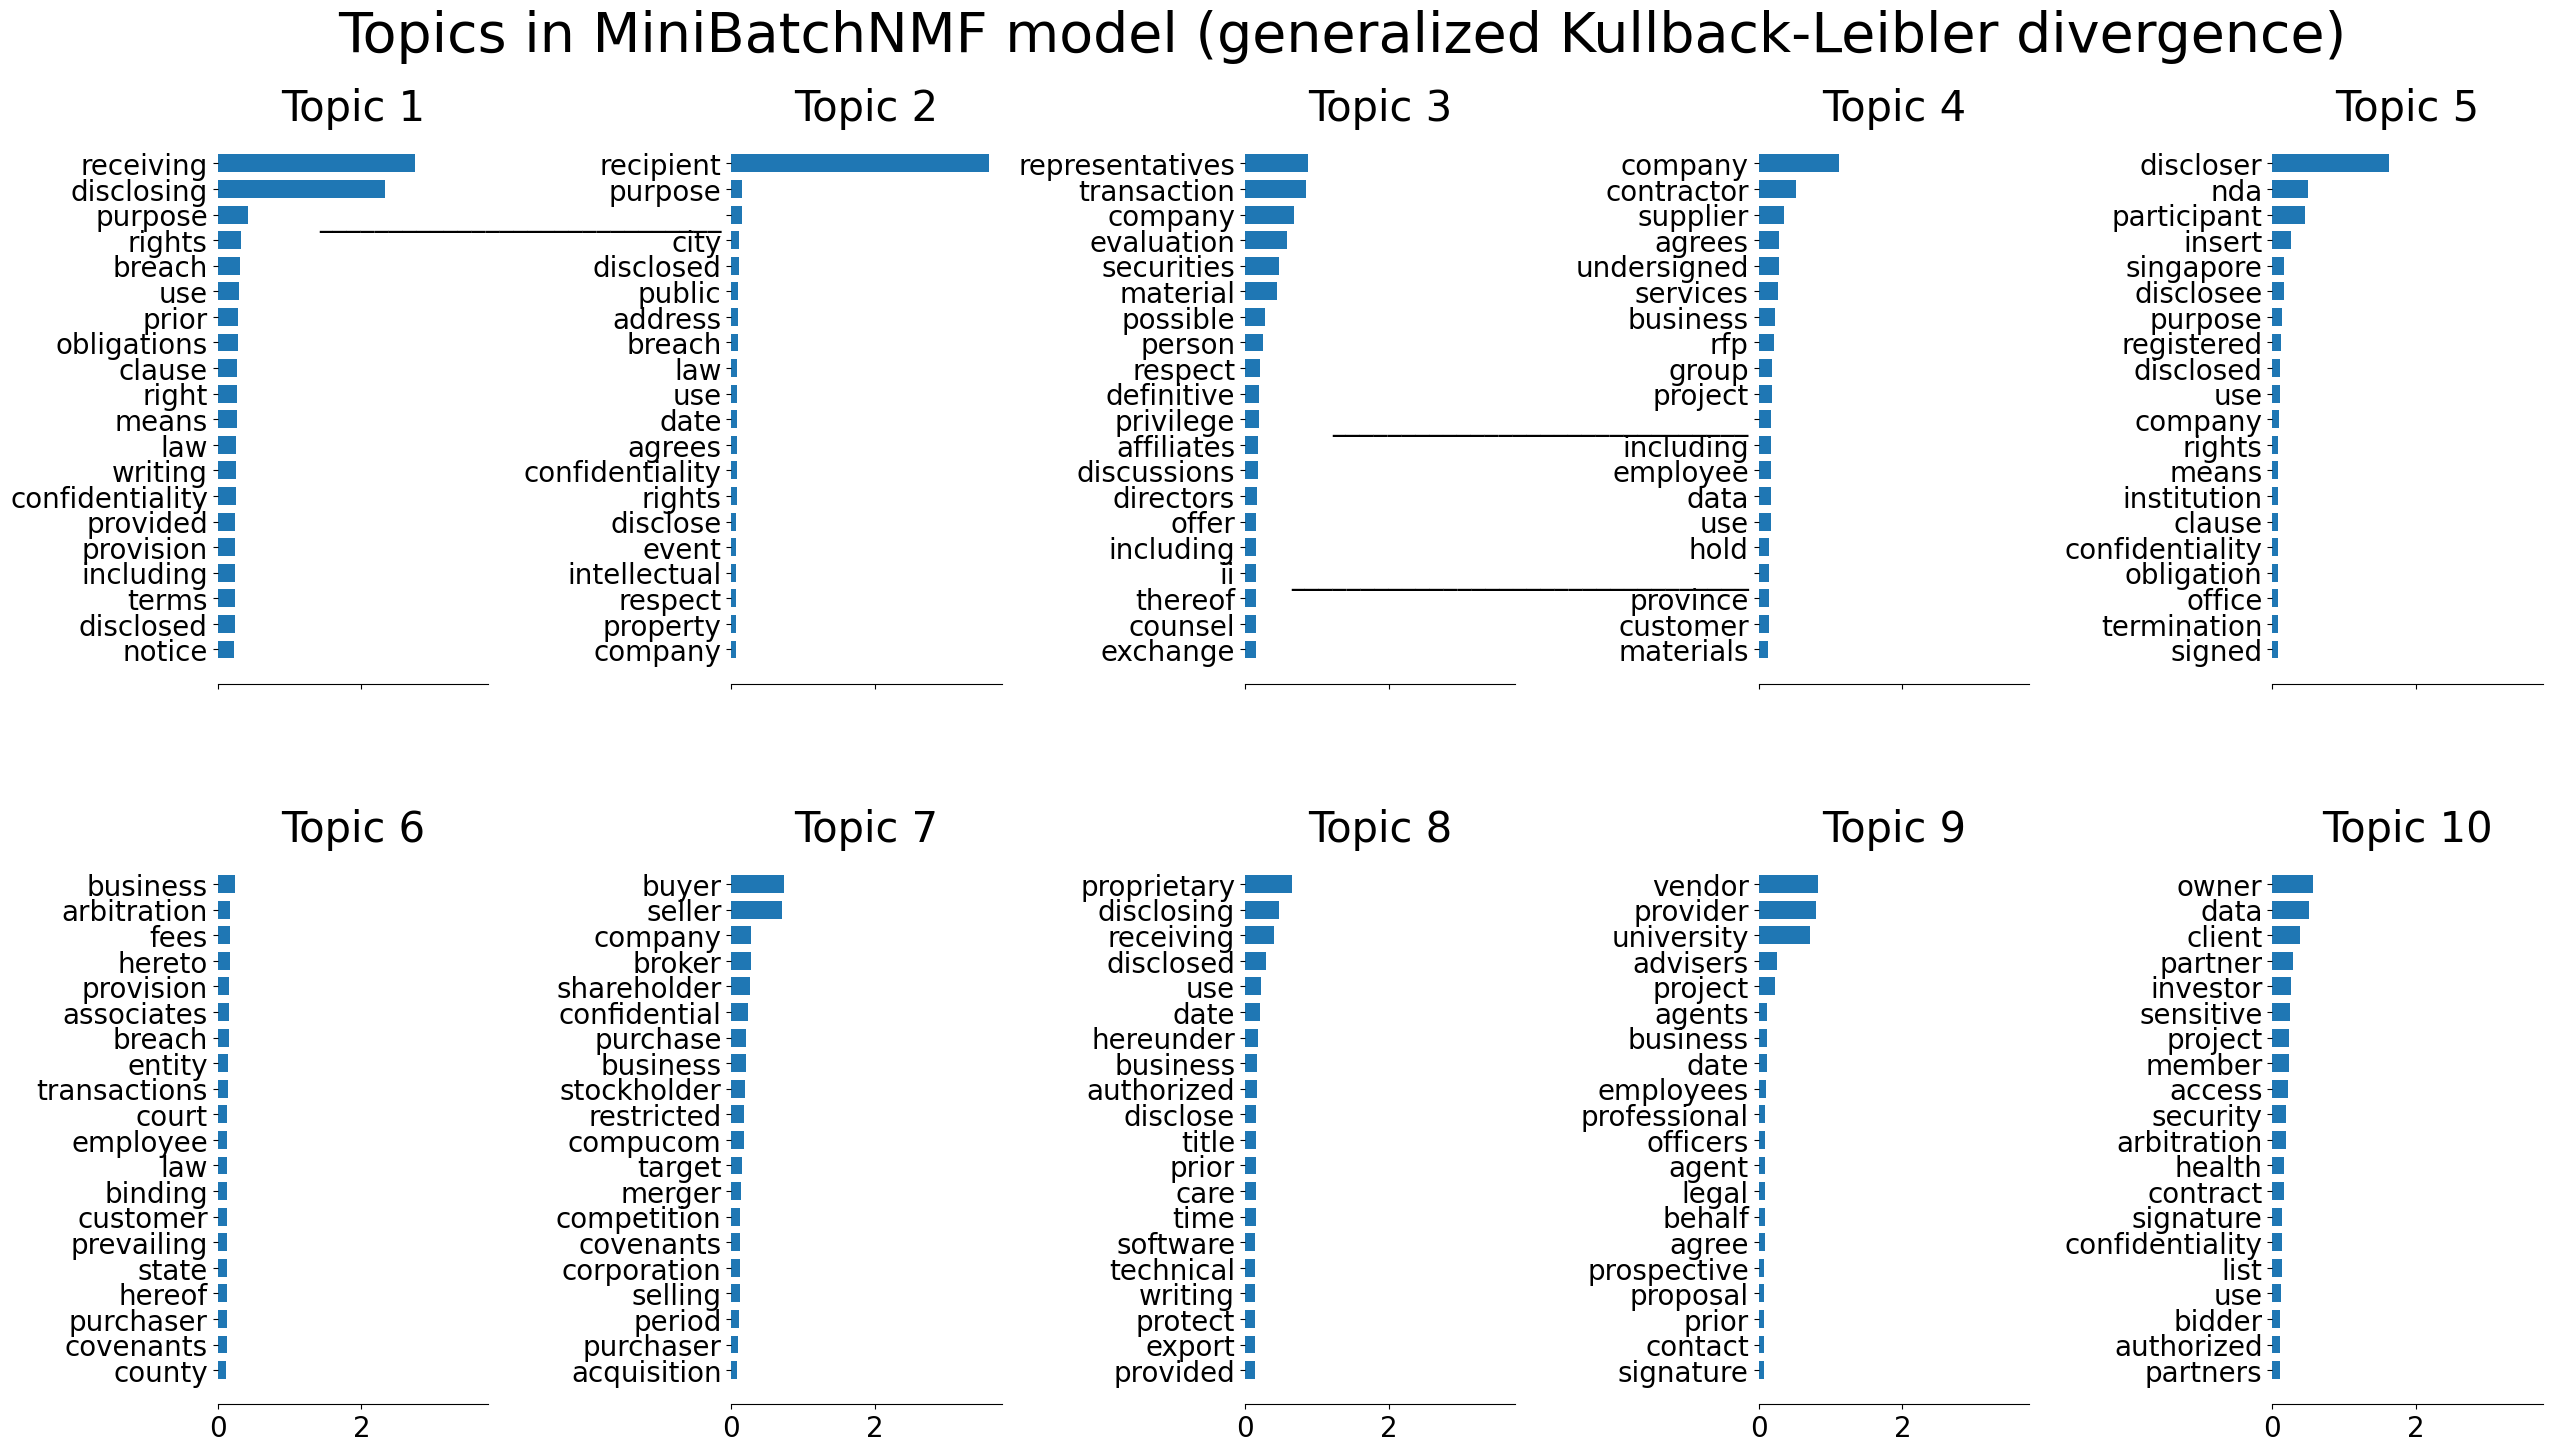



 Fitting LDA models with tf features and n_features=1000...
done in 1.557s.


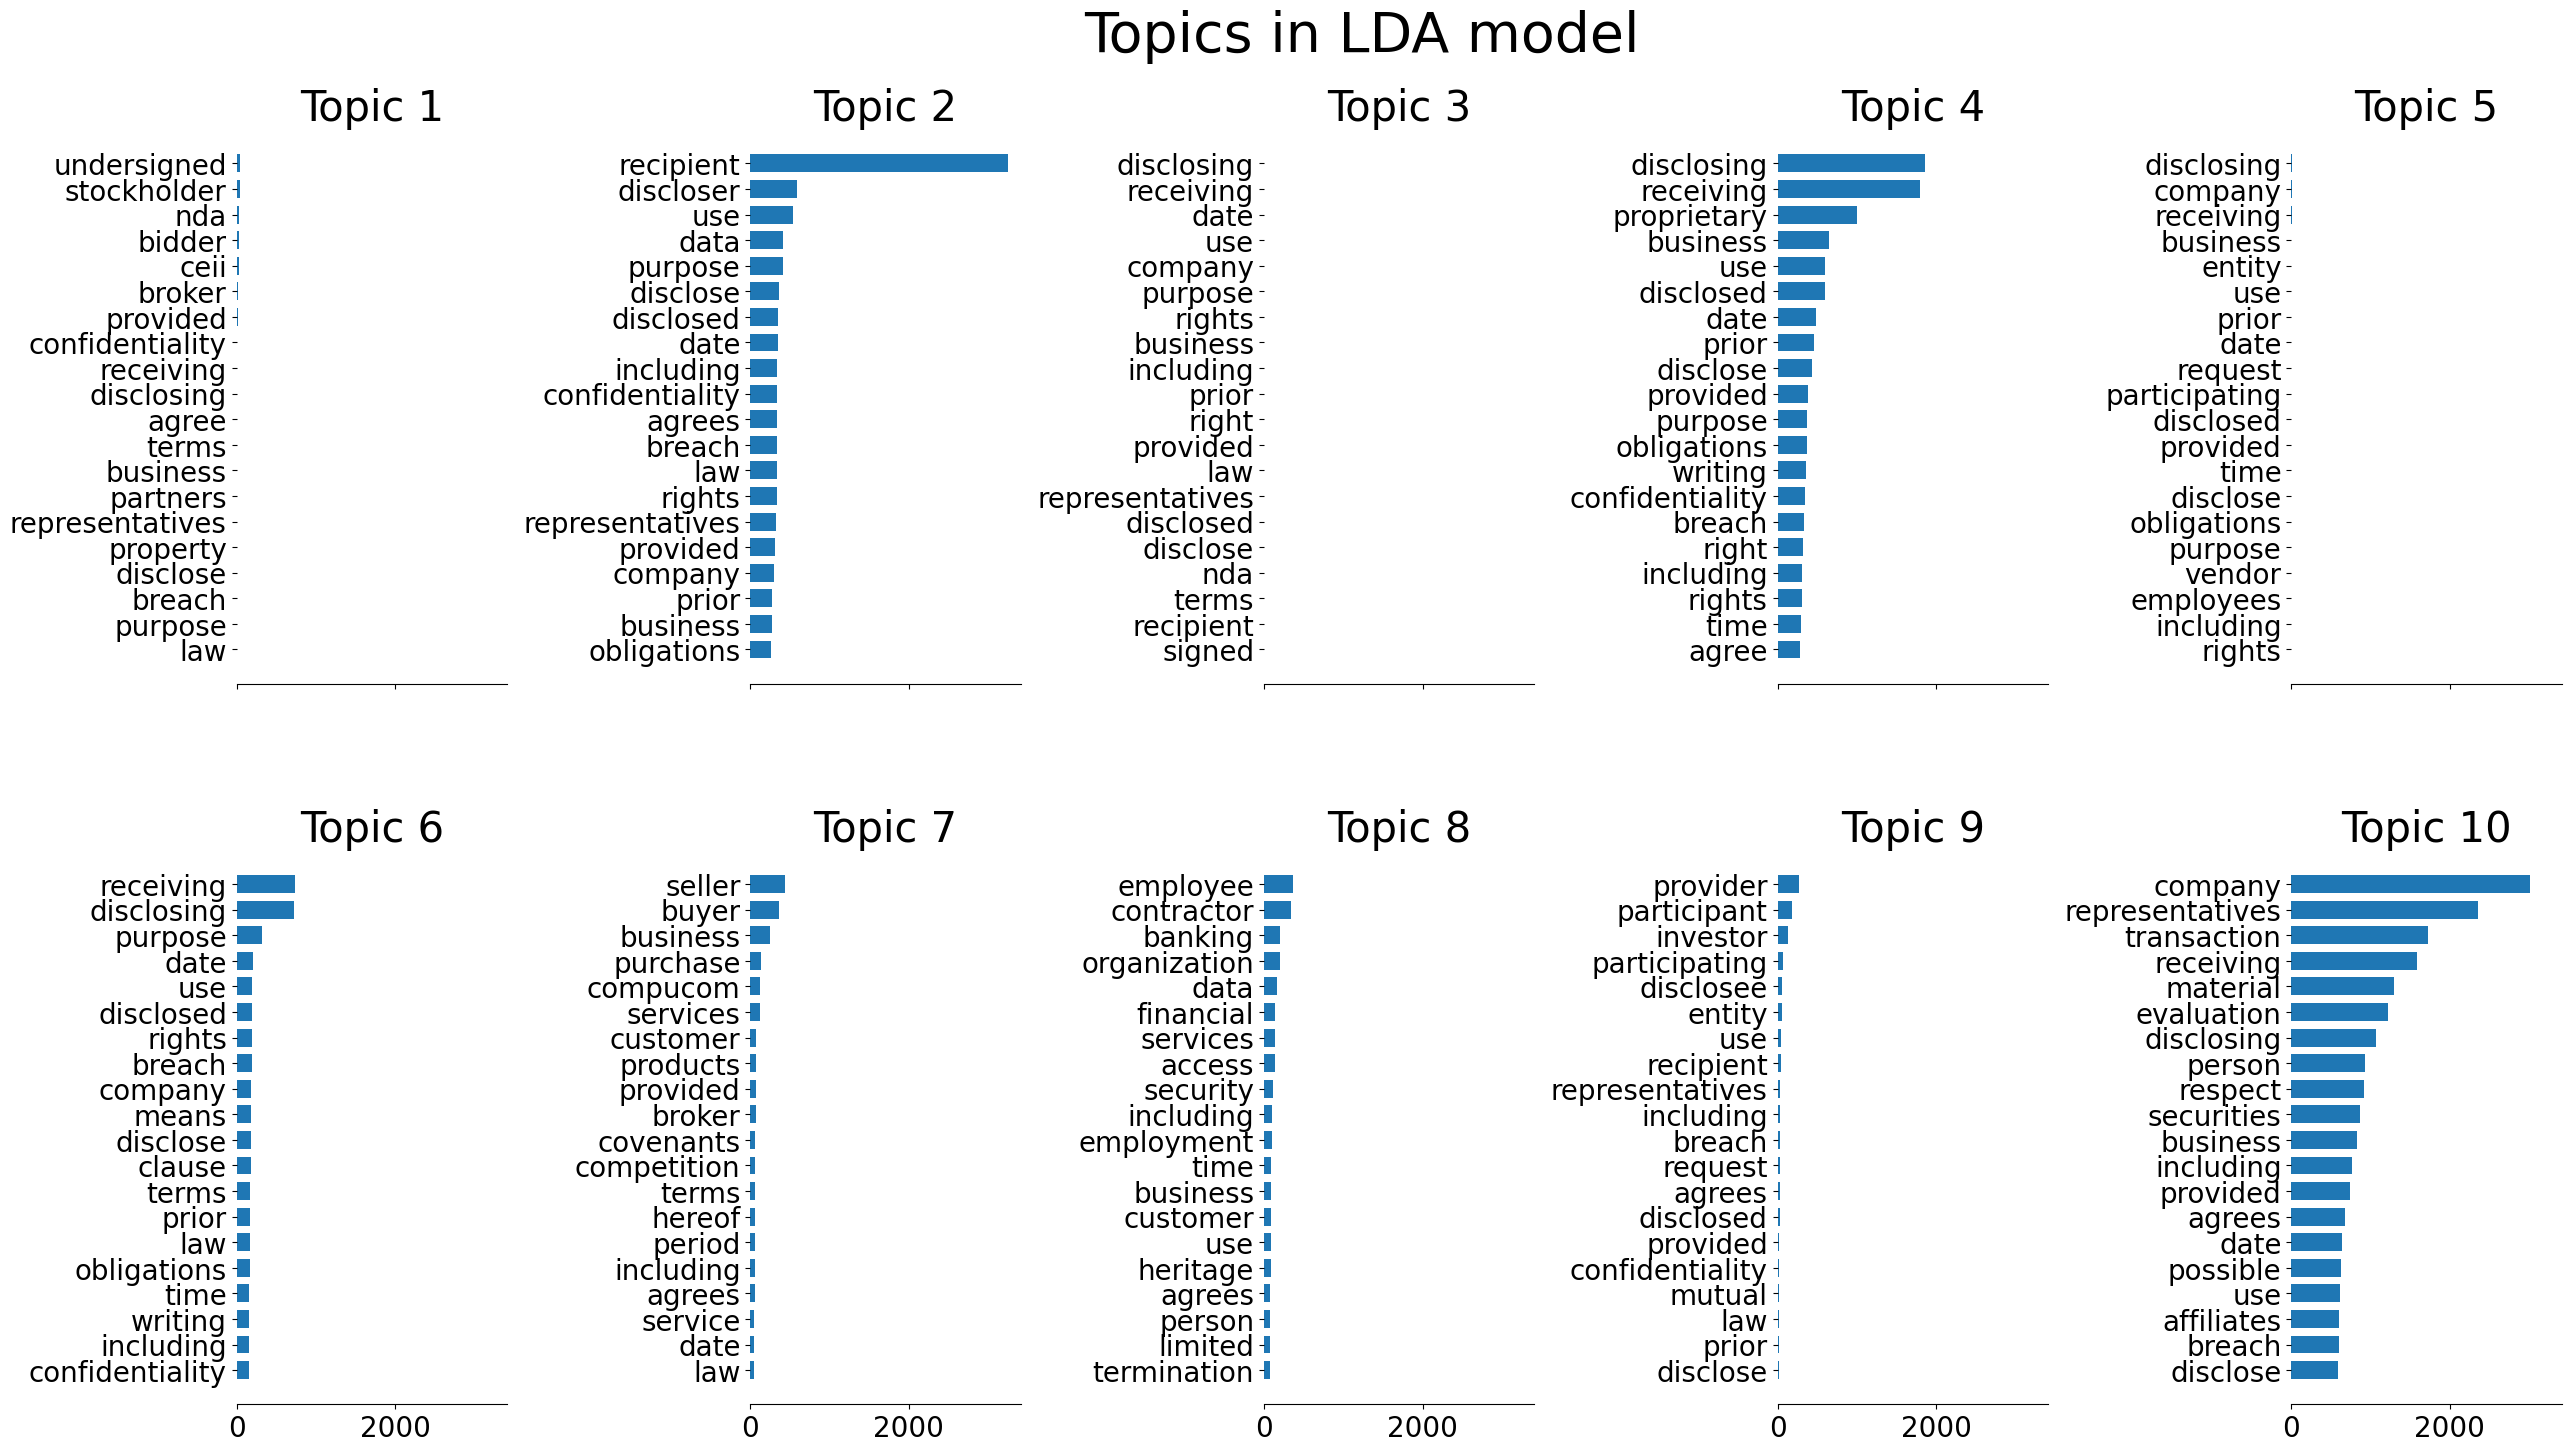

In [5]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    """Plot the top words for each topic in the model.

    Parameters
    ----------
    model : object
        The topic model (NMF, LDA, etc.) that contains the components_ attribute
    feature_names : array-like
        The names of the features (words) corresponding to each component
    n_top_words : int
        Number of top words to display for each topic
    title : str
        Title for the plot

    Returns
    -------
    None
        Displays a matplotlib figure with subplots for each topic

    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in ["top", "right", "left"]:
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

dataset = cnli_text

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
t0 = time()
tf = tf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    f"n_features={n_features}..."
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")

# Fit the NMF model
print(
    "\n" * 2,
    f"Fitting the NMF model (generalized Kullback-Leibler "
    f"divergence) with tf-idf features, n_features={n_features}..."
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    f"Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    f"features, n_features={n_features}, batch_size={batch_size}..."
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    f"Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    f"divergence) with tf-idf features and n_features={n_features}, "
    f"batch_size={batch_size}..."
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    f"Fitting LDA models with tf features and n_features={n_features}..."
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

## CUAD and Contract NLI

Extracting tf-idf features for NMF...
done in 1.940s.
Extracting tf features for LDA...
done in 1.897s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_features=1000...


/home/cethan/GitHub/542-LegalContract-AI/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 1.049s.


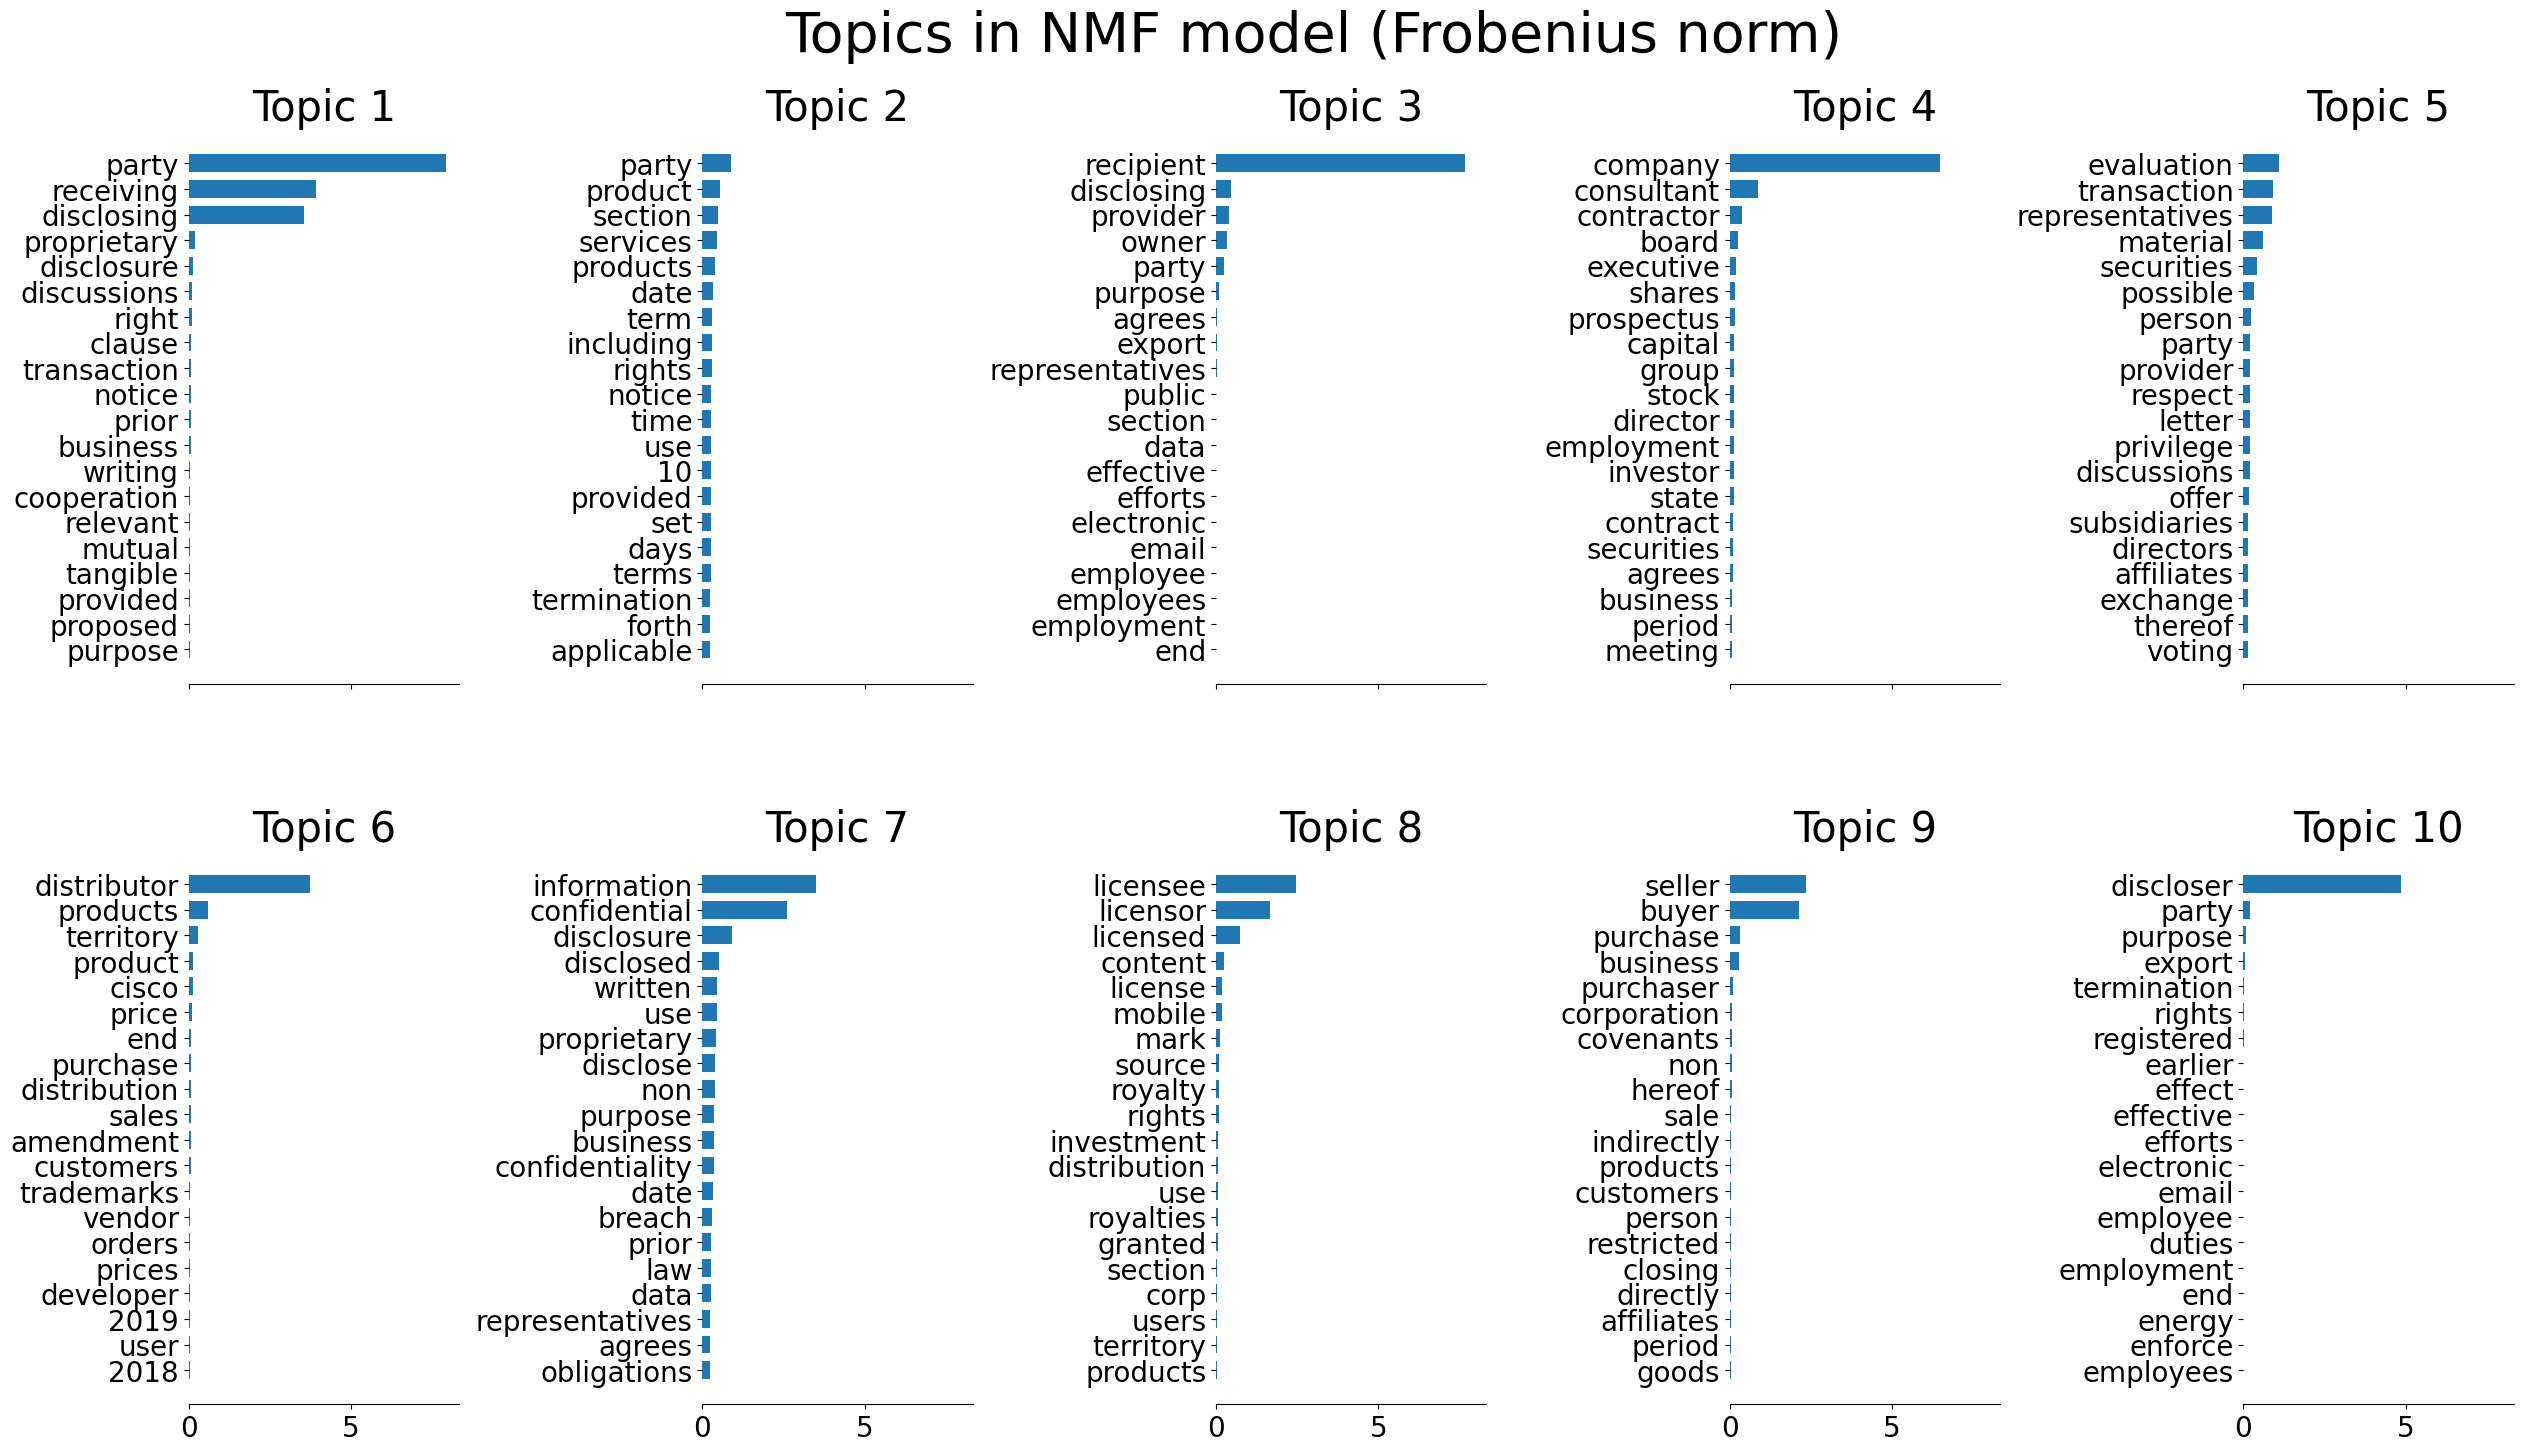



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_features=1000...
done in 8.895s.


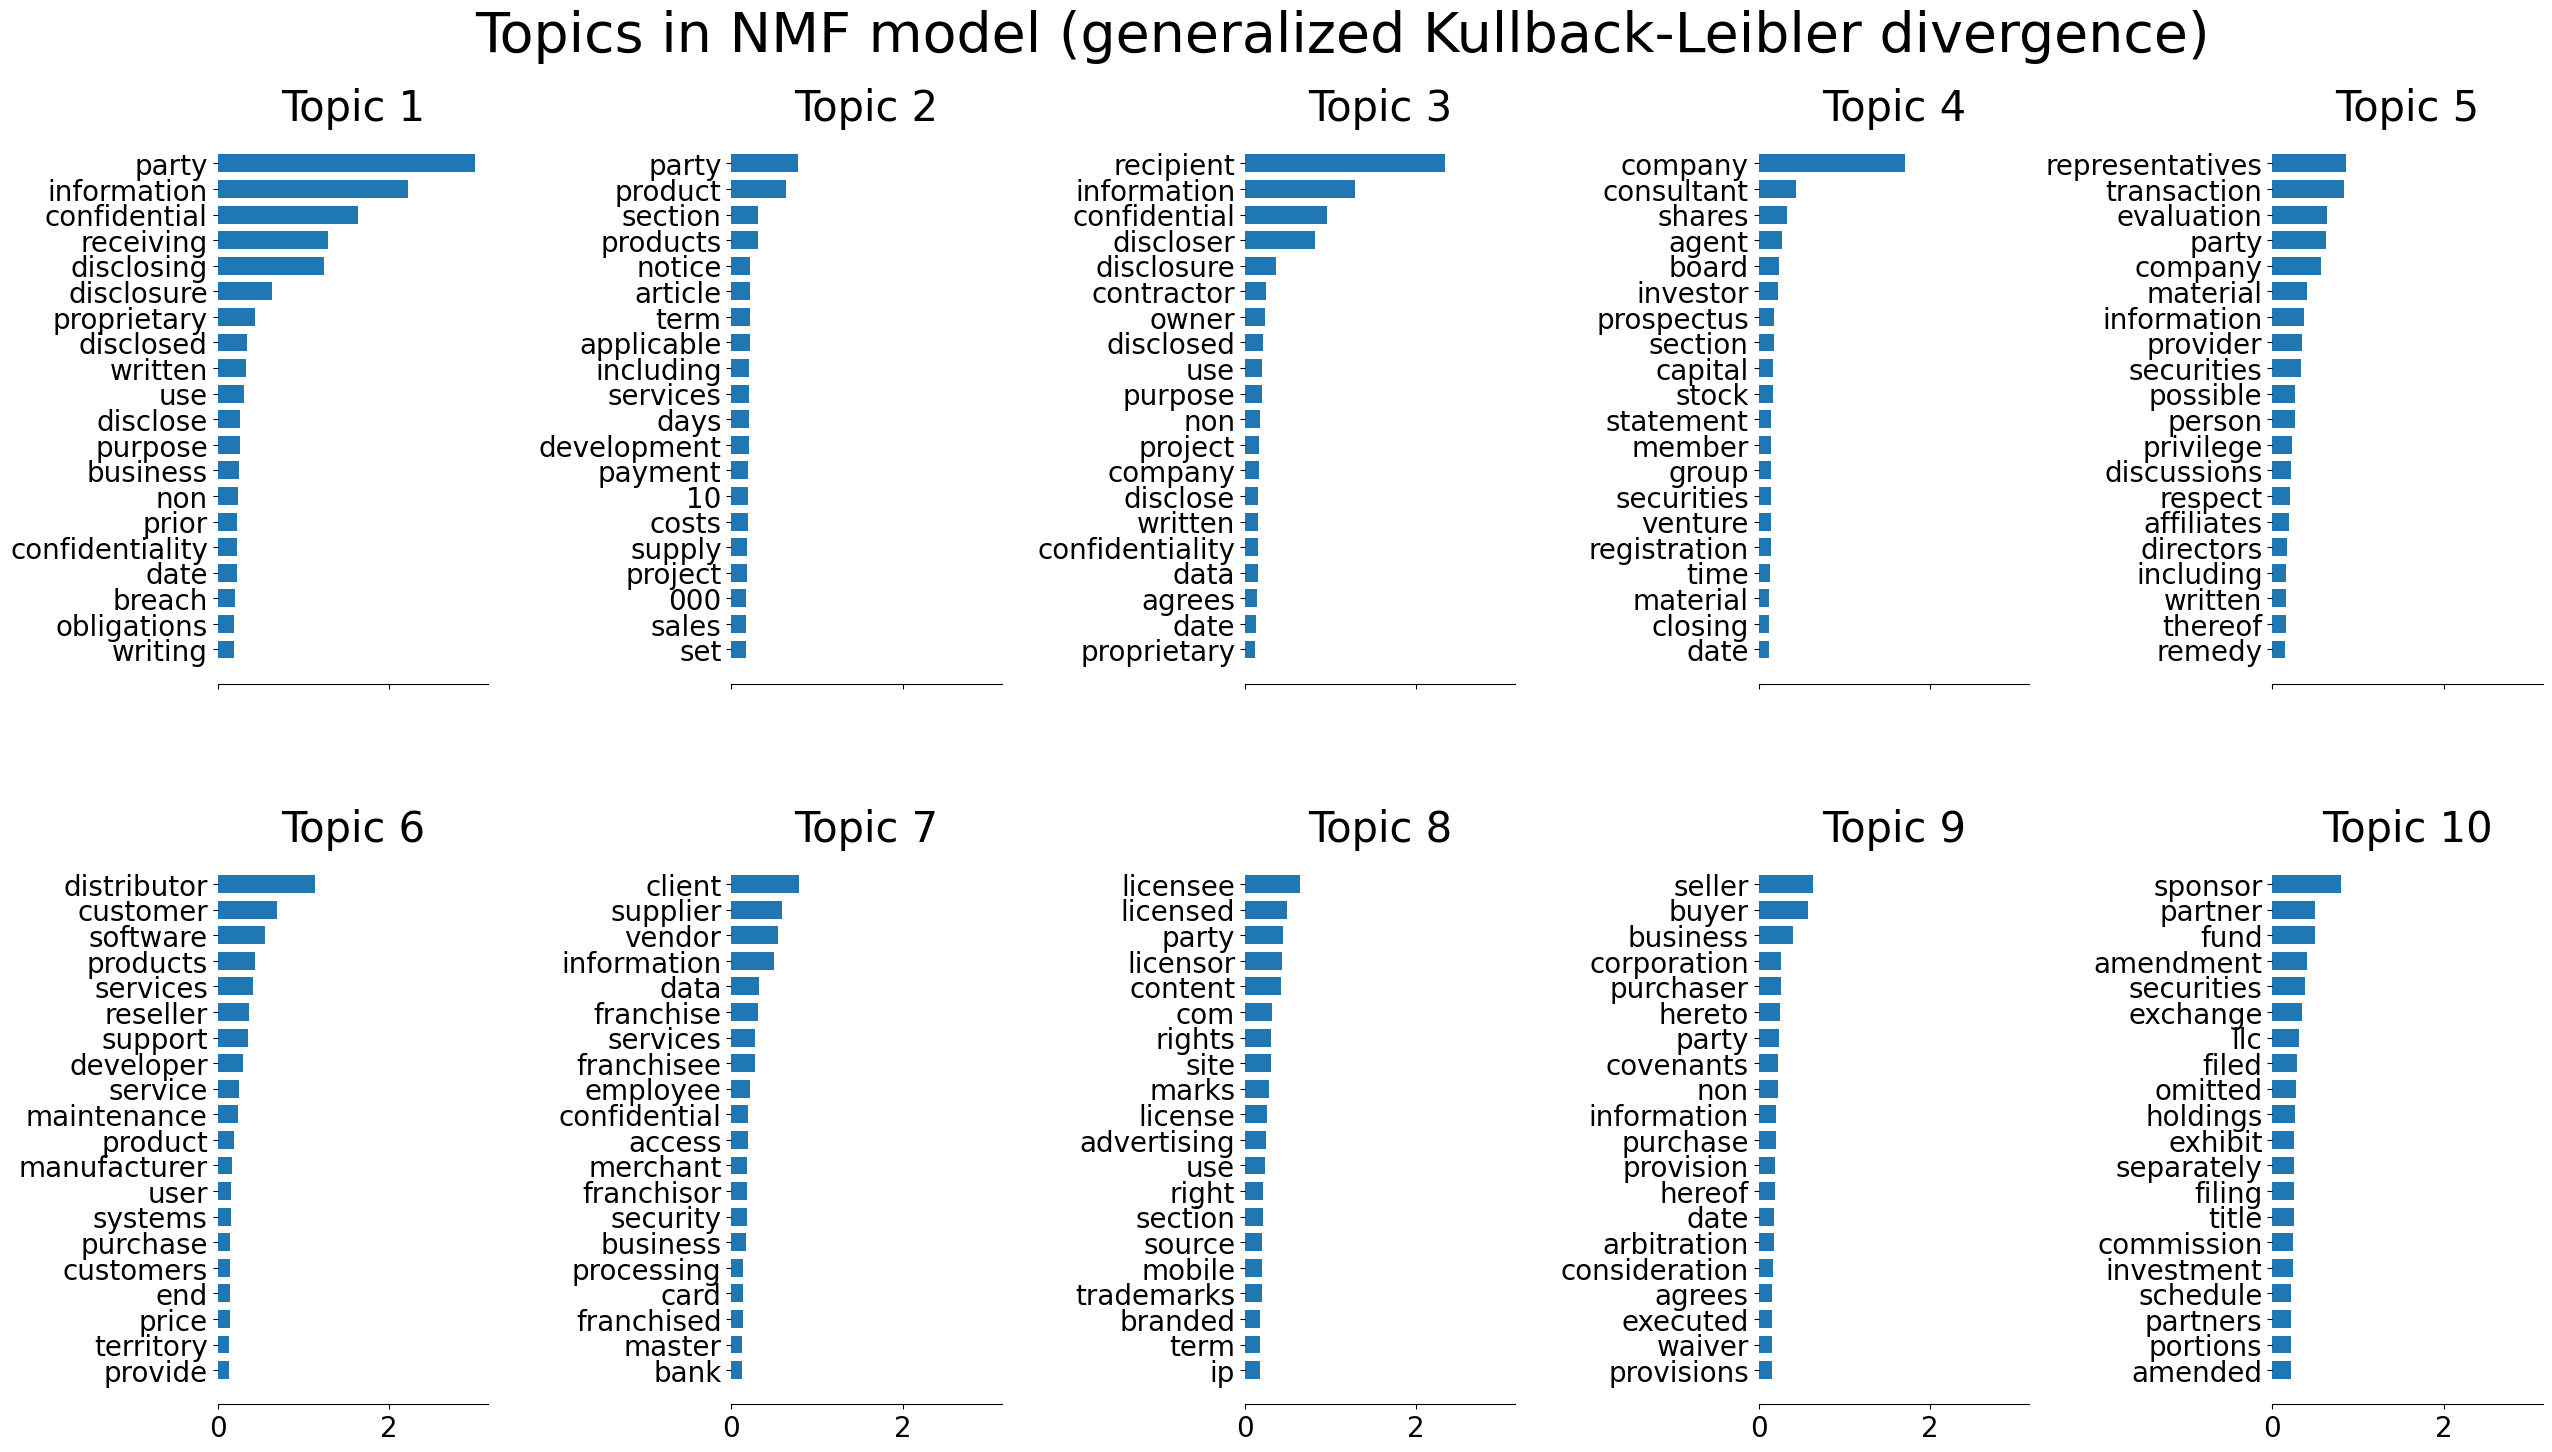



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_features=1000, batch_size=128...


/home/cethan/GitHub/542-LegalContract-AI/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:2328: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 36.795s.


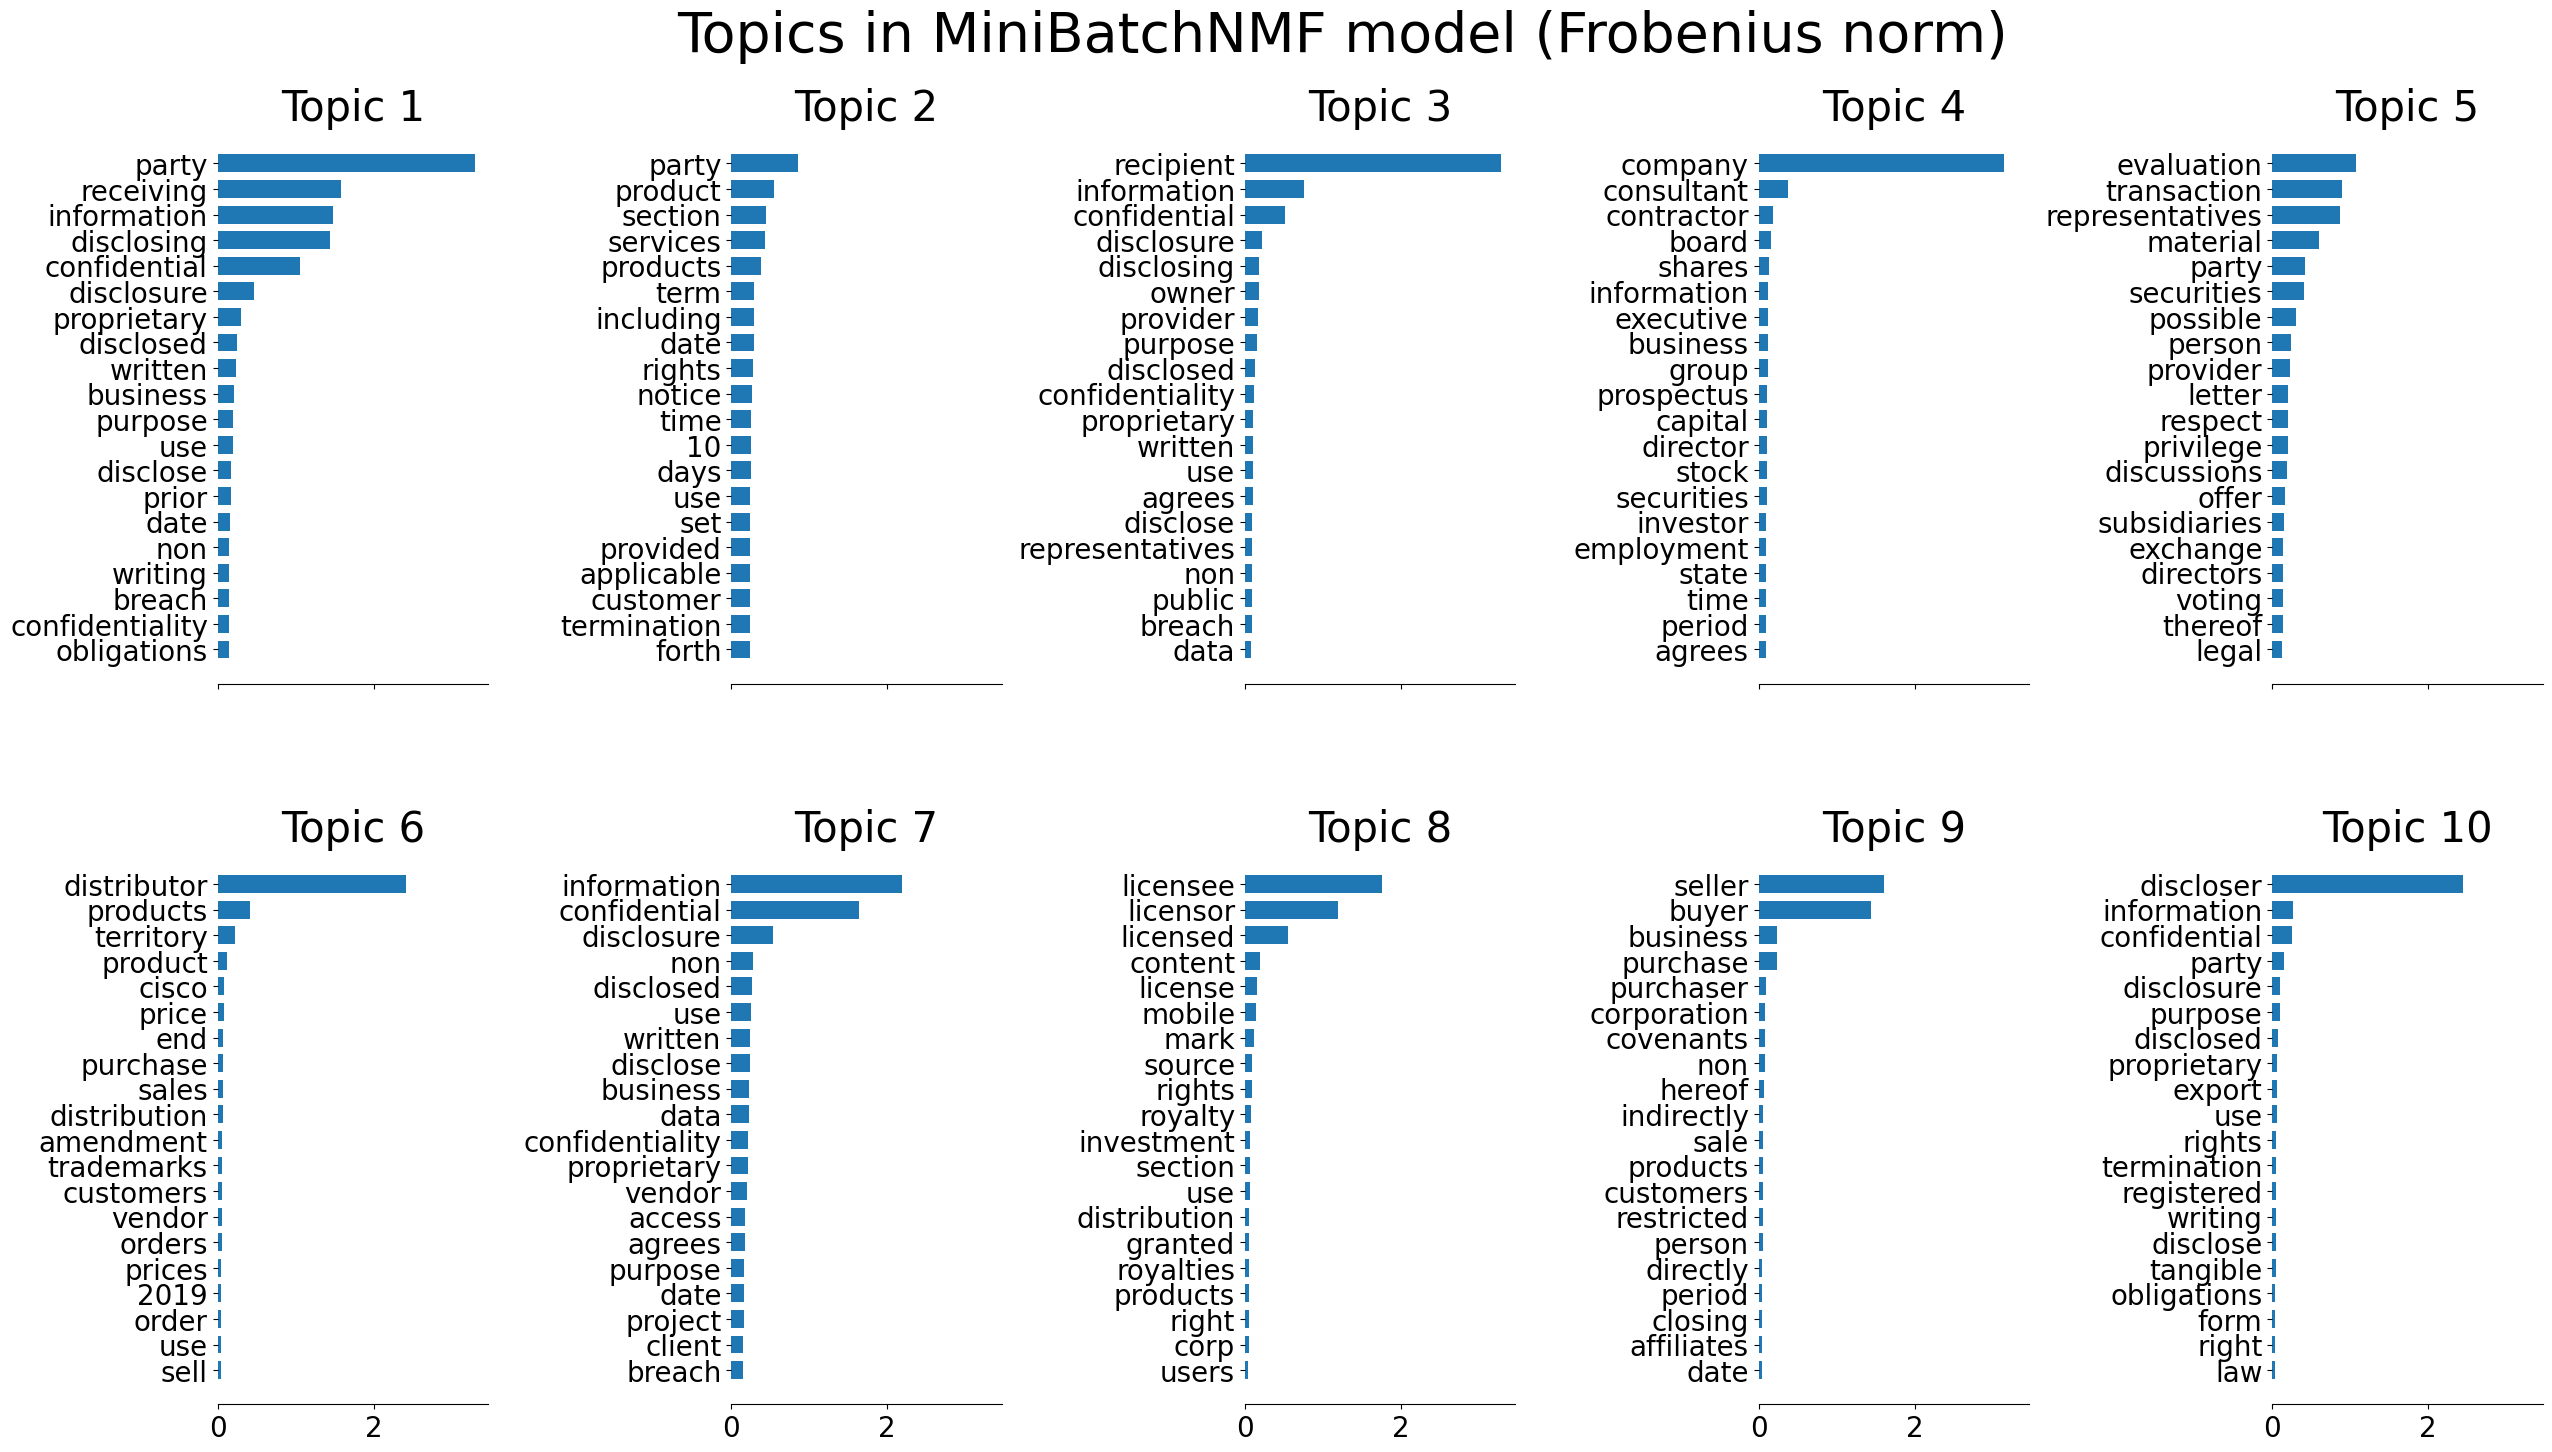



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features and n_features=1000, batch_size=128...
done in 45.309s.


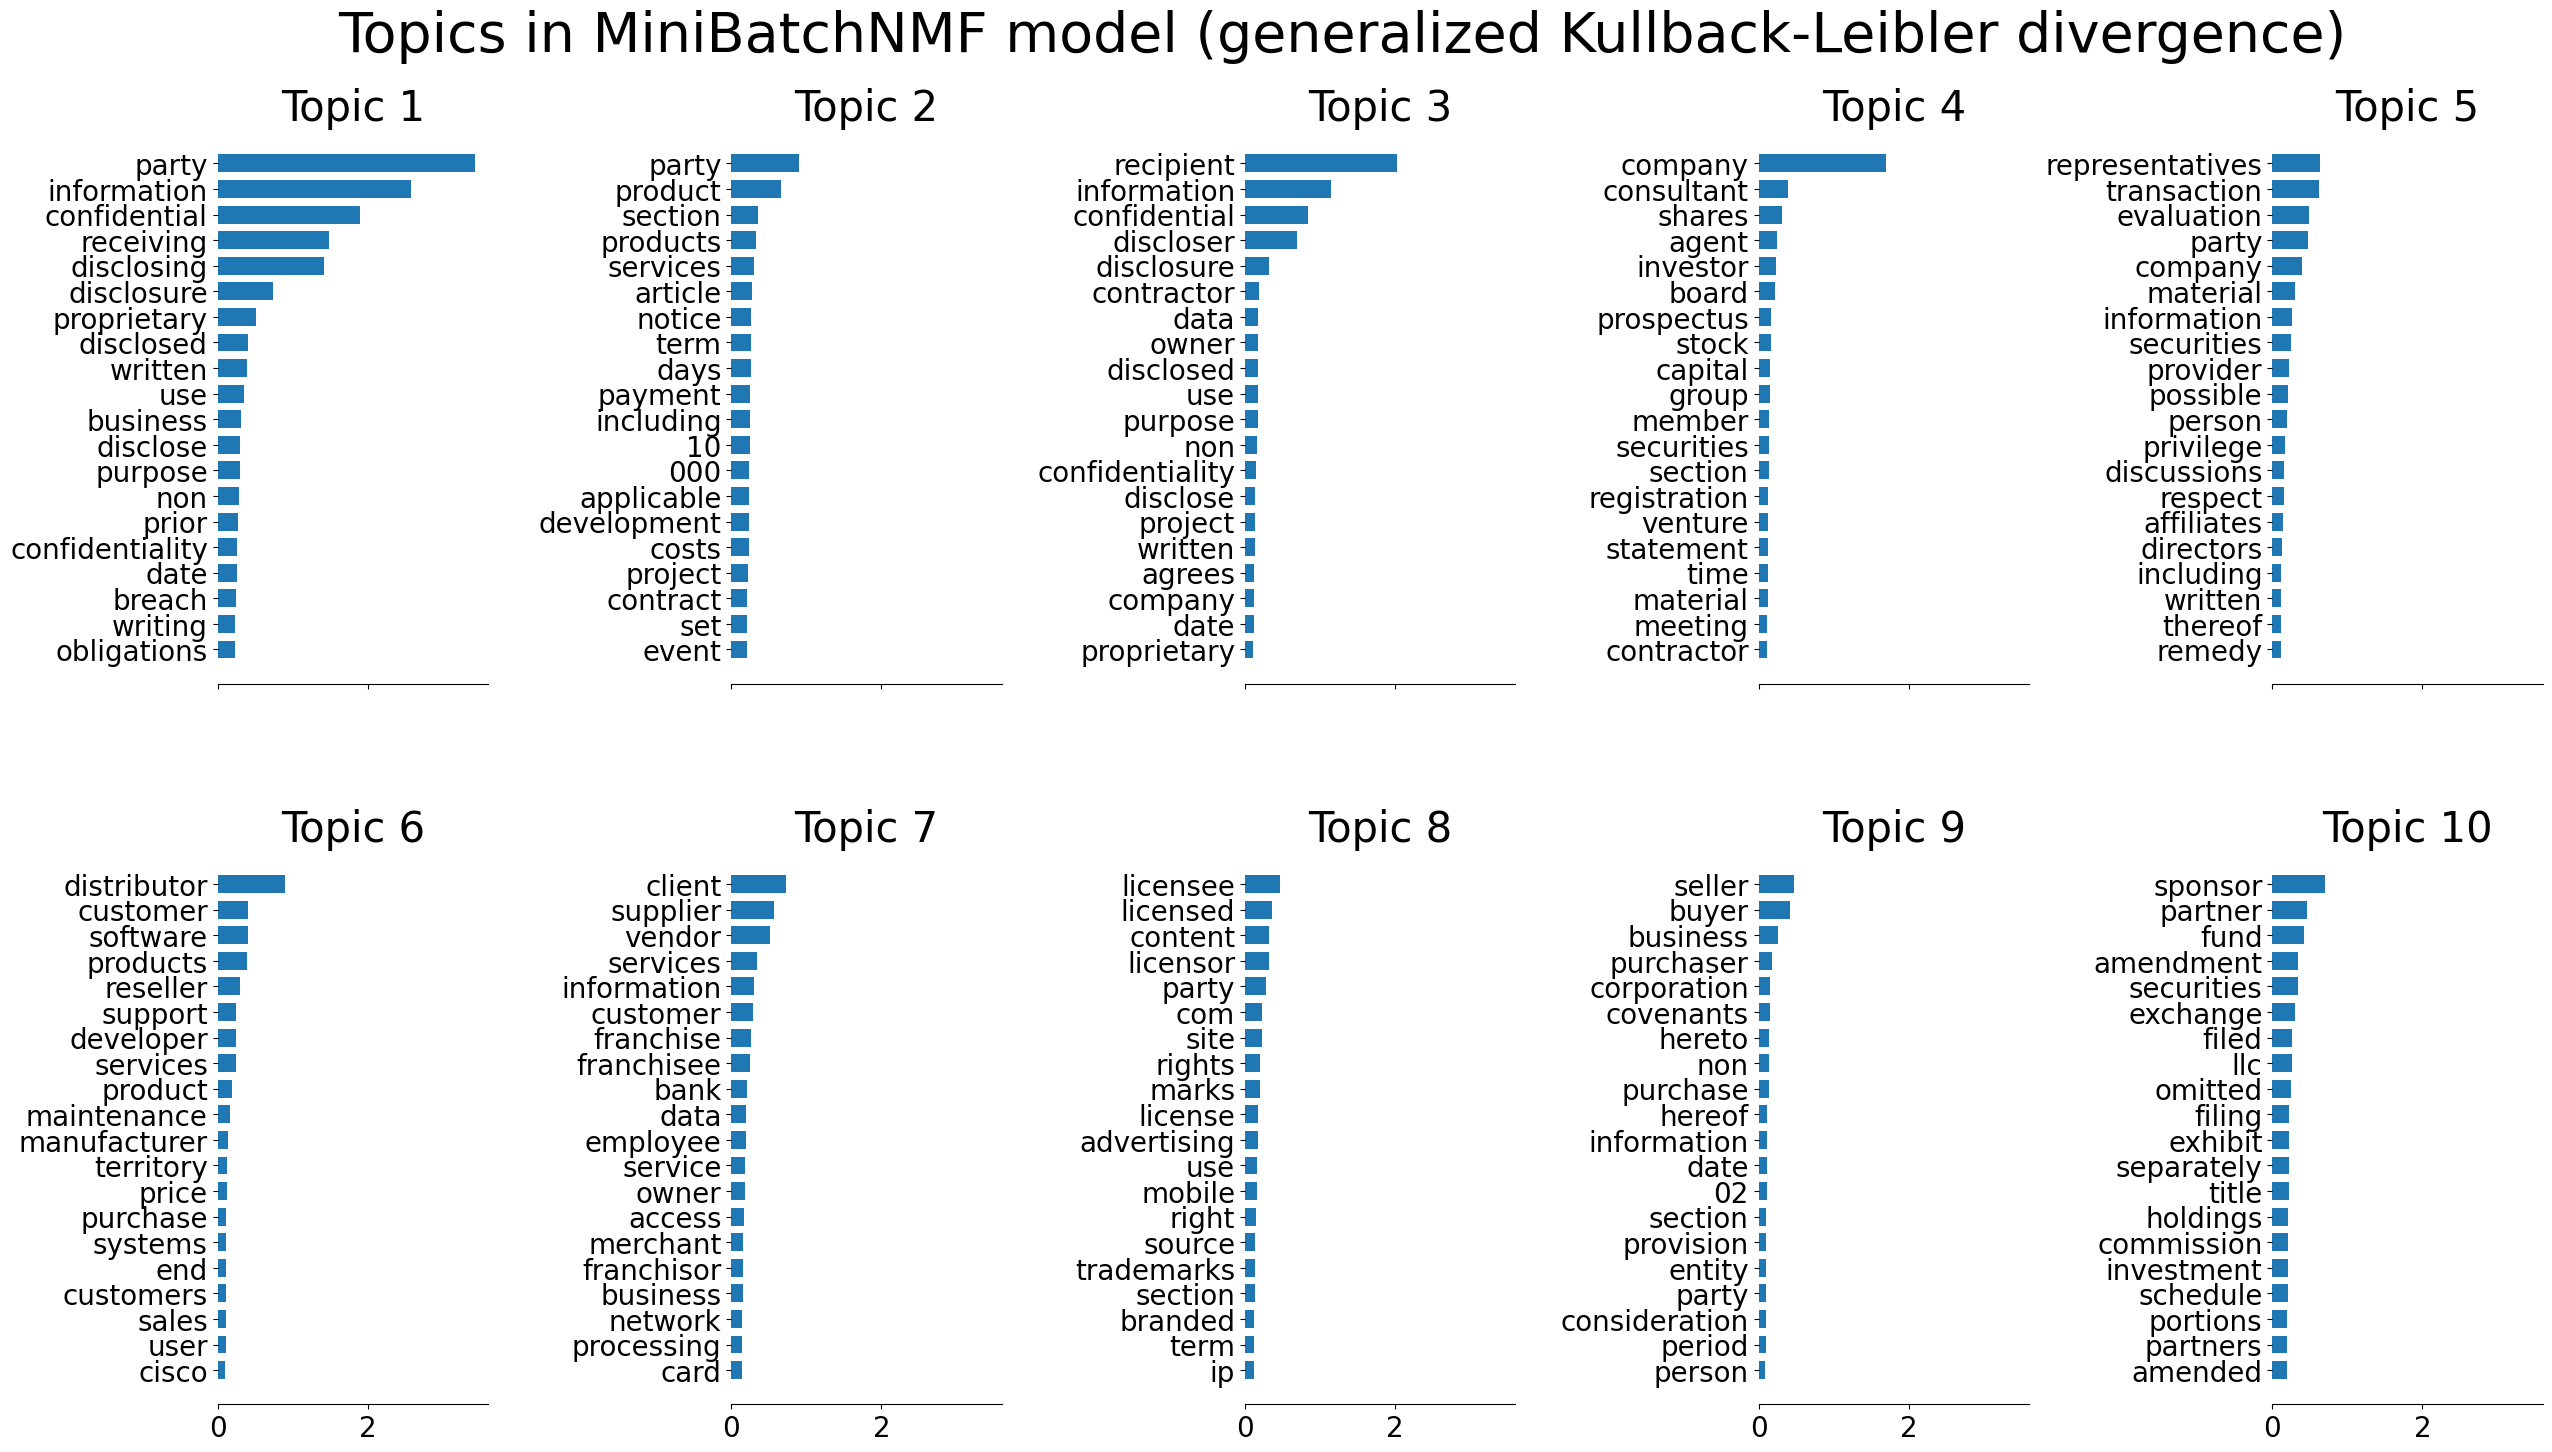



 Fitting LDA models with tf features and n_features=1000...
done in 2.910s.


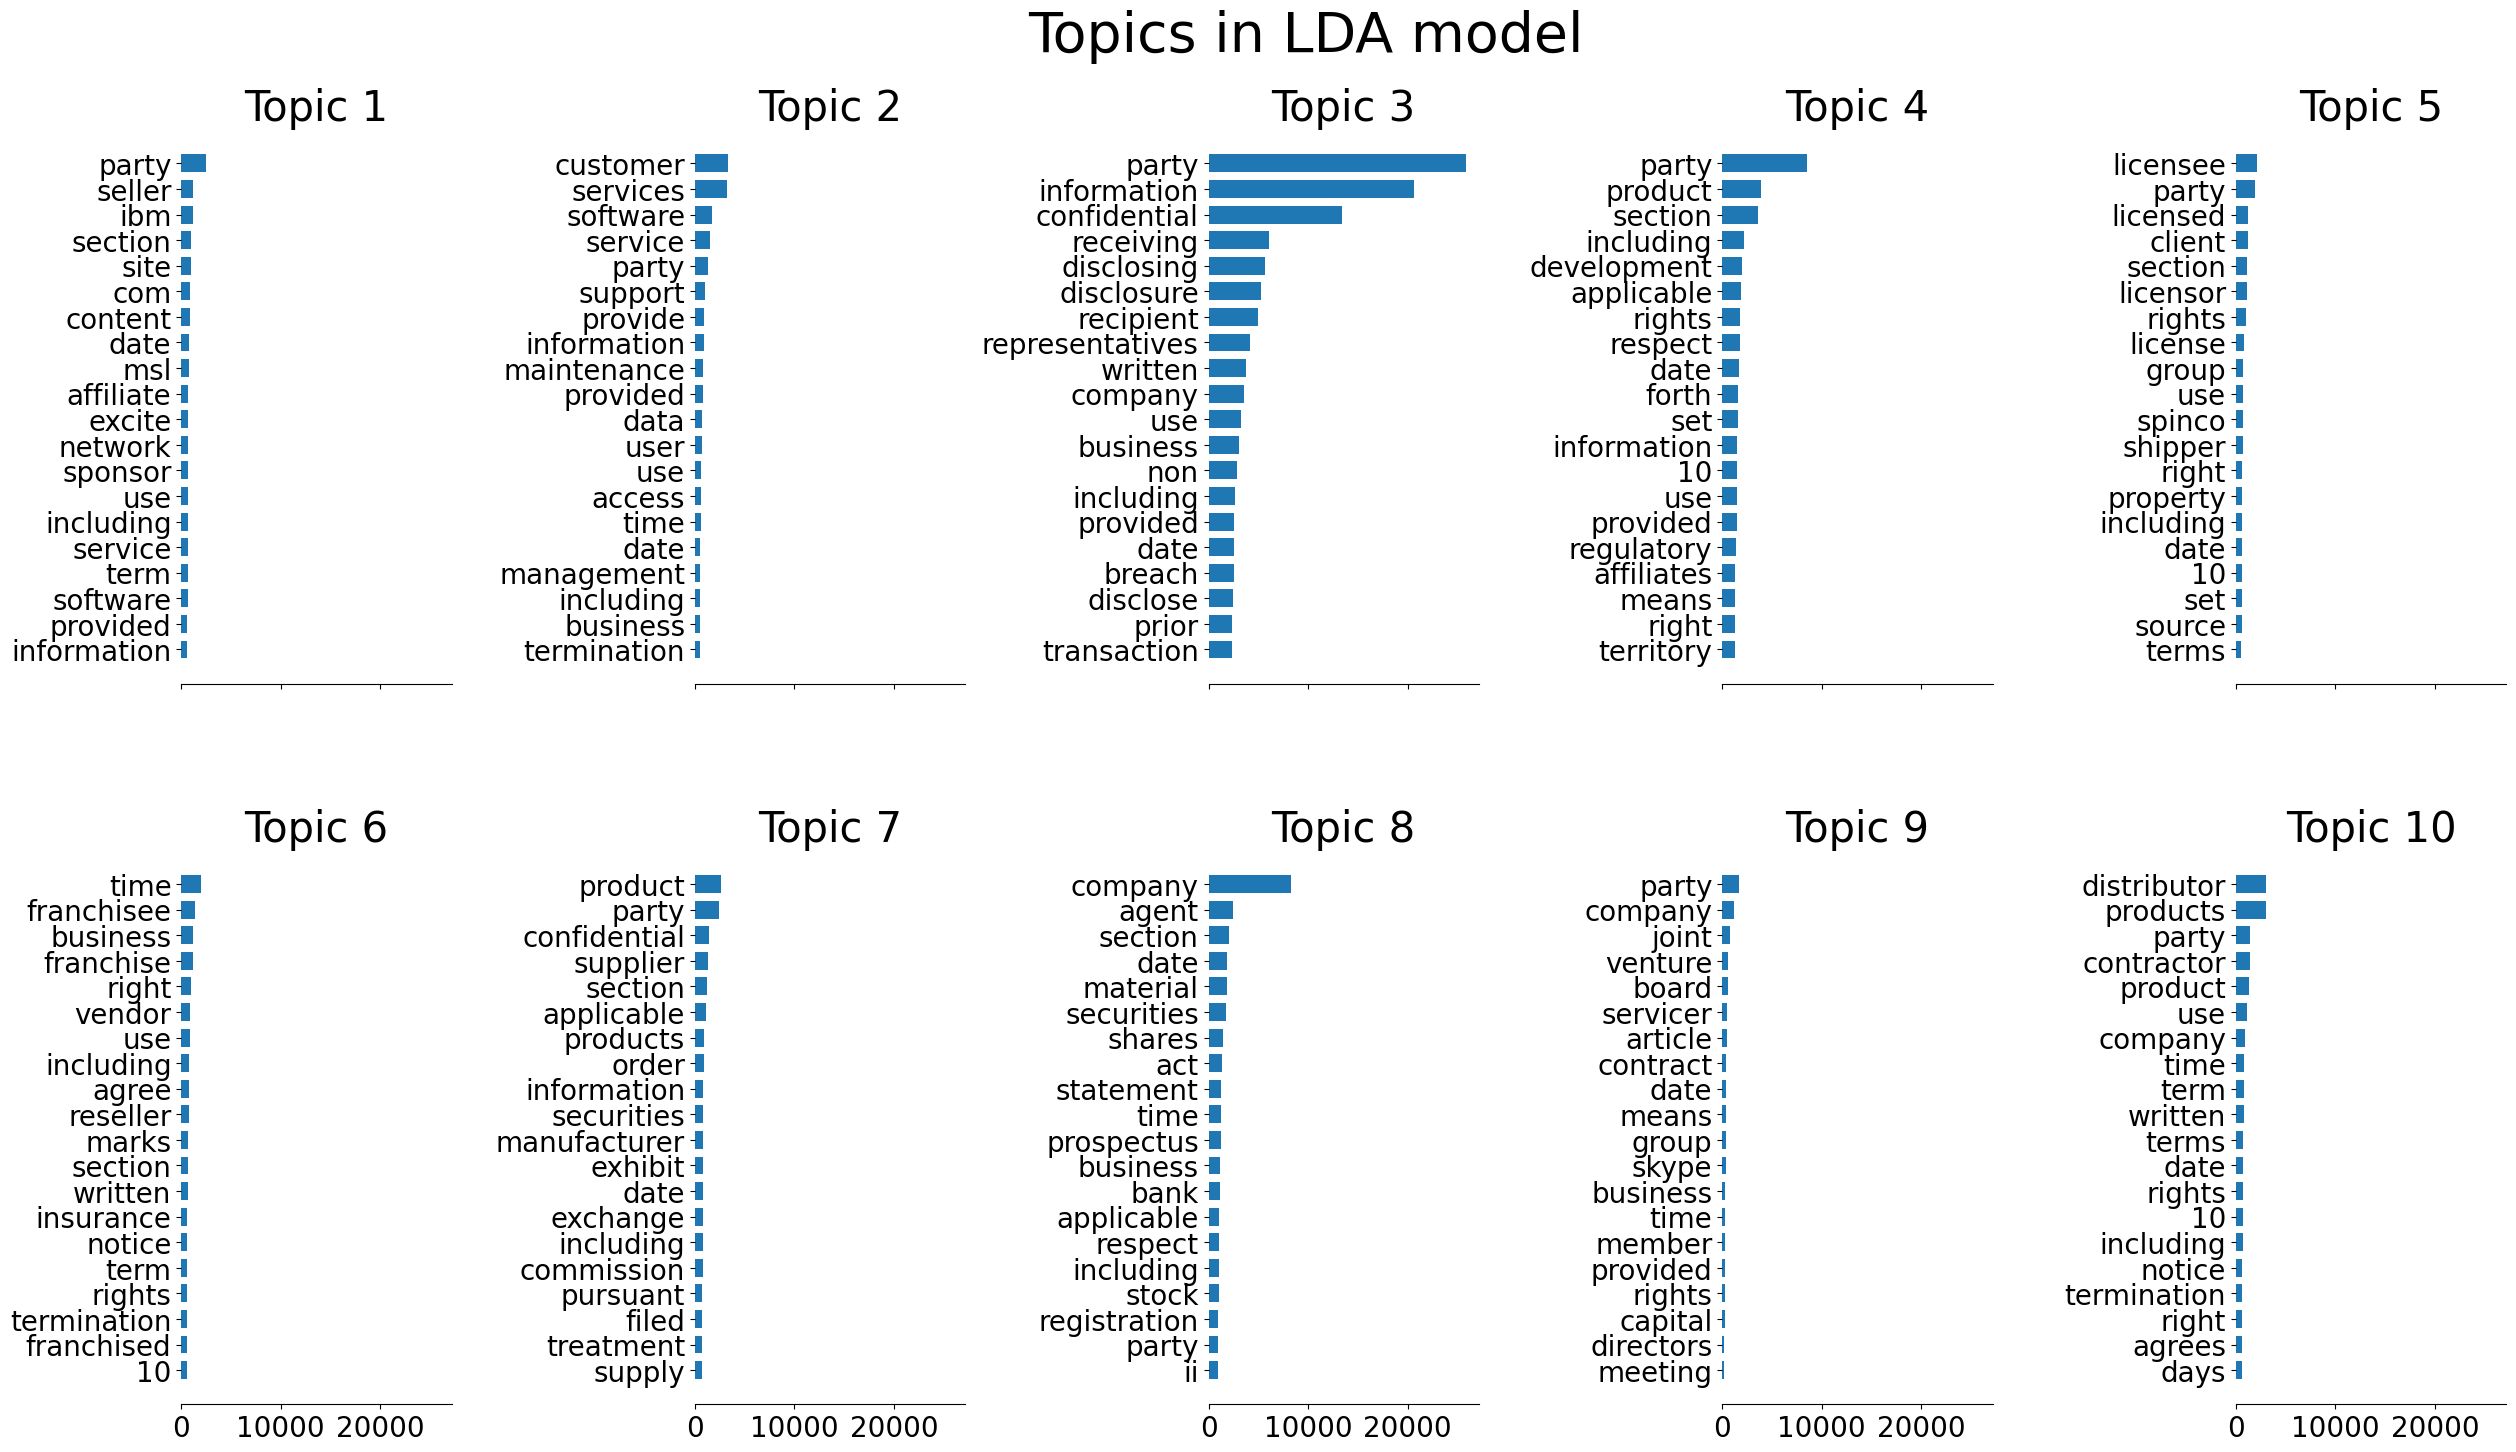

In [8]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    """Plot the top words for each topic in the model.

    Parameters
    ----------
    model : object
        The topic model (NMF, LDA, etc.) that contains the components_ attribute
    feature_names : array-like
        The names of the features (words) corresponding to each component
    n_top_words : int
        Number of top words to display for each topic
    title : str
        Title for the plot

    Returns
    -------
    None
        Displays a matplotlib figure with subplots for each topic

    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in ["top", "right", "left"]:
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

dataset = cuad_text + cnli_text

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
t0 = time()
tf = tf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    f"n_features={n_features}..."
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")

# Fit the NMF model
print(
    "\n" * 2,
    f"Fitting the NMF model (generalized Kullback-Leibler "
    f"divergence) with tf-idf features, n_features={n_features}..."
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    f"Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    f"features, n_features={n_features}, batch_size={batch_size}..."
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    f"Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    f"divergence) with tf-idf features and n_features={n_features}, "
    f"batch_size={batch_size}..."
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    f"Fitting LDA models with tf features and n_features={n_features}..."
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")